In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pysindy as ps
import networkx as nx
import scipy
import math
import cmath
from scipy import stats

from scipy.integrate import odeint

from scipy import signal
from IPython.display import Image
%matplotlib inline 


from numpy import linalg as LA
import scipy.io

import seaborn as sns
import pandas as pd
import ggseg

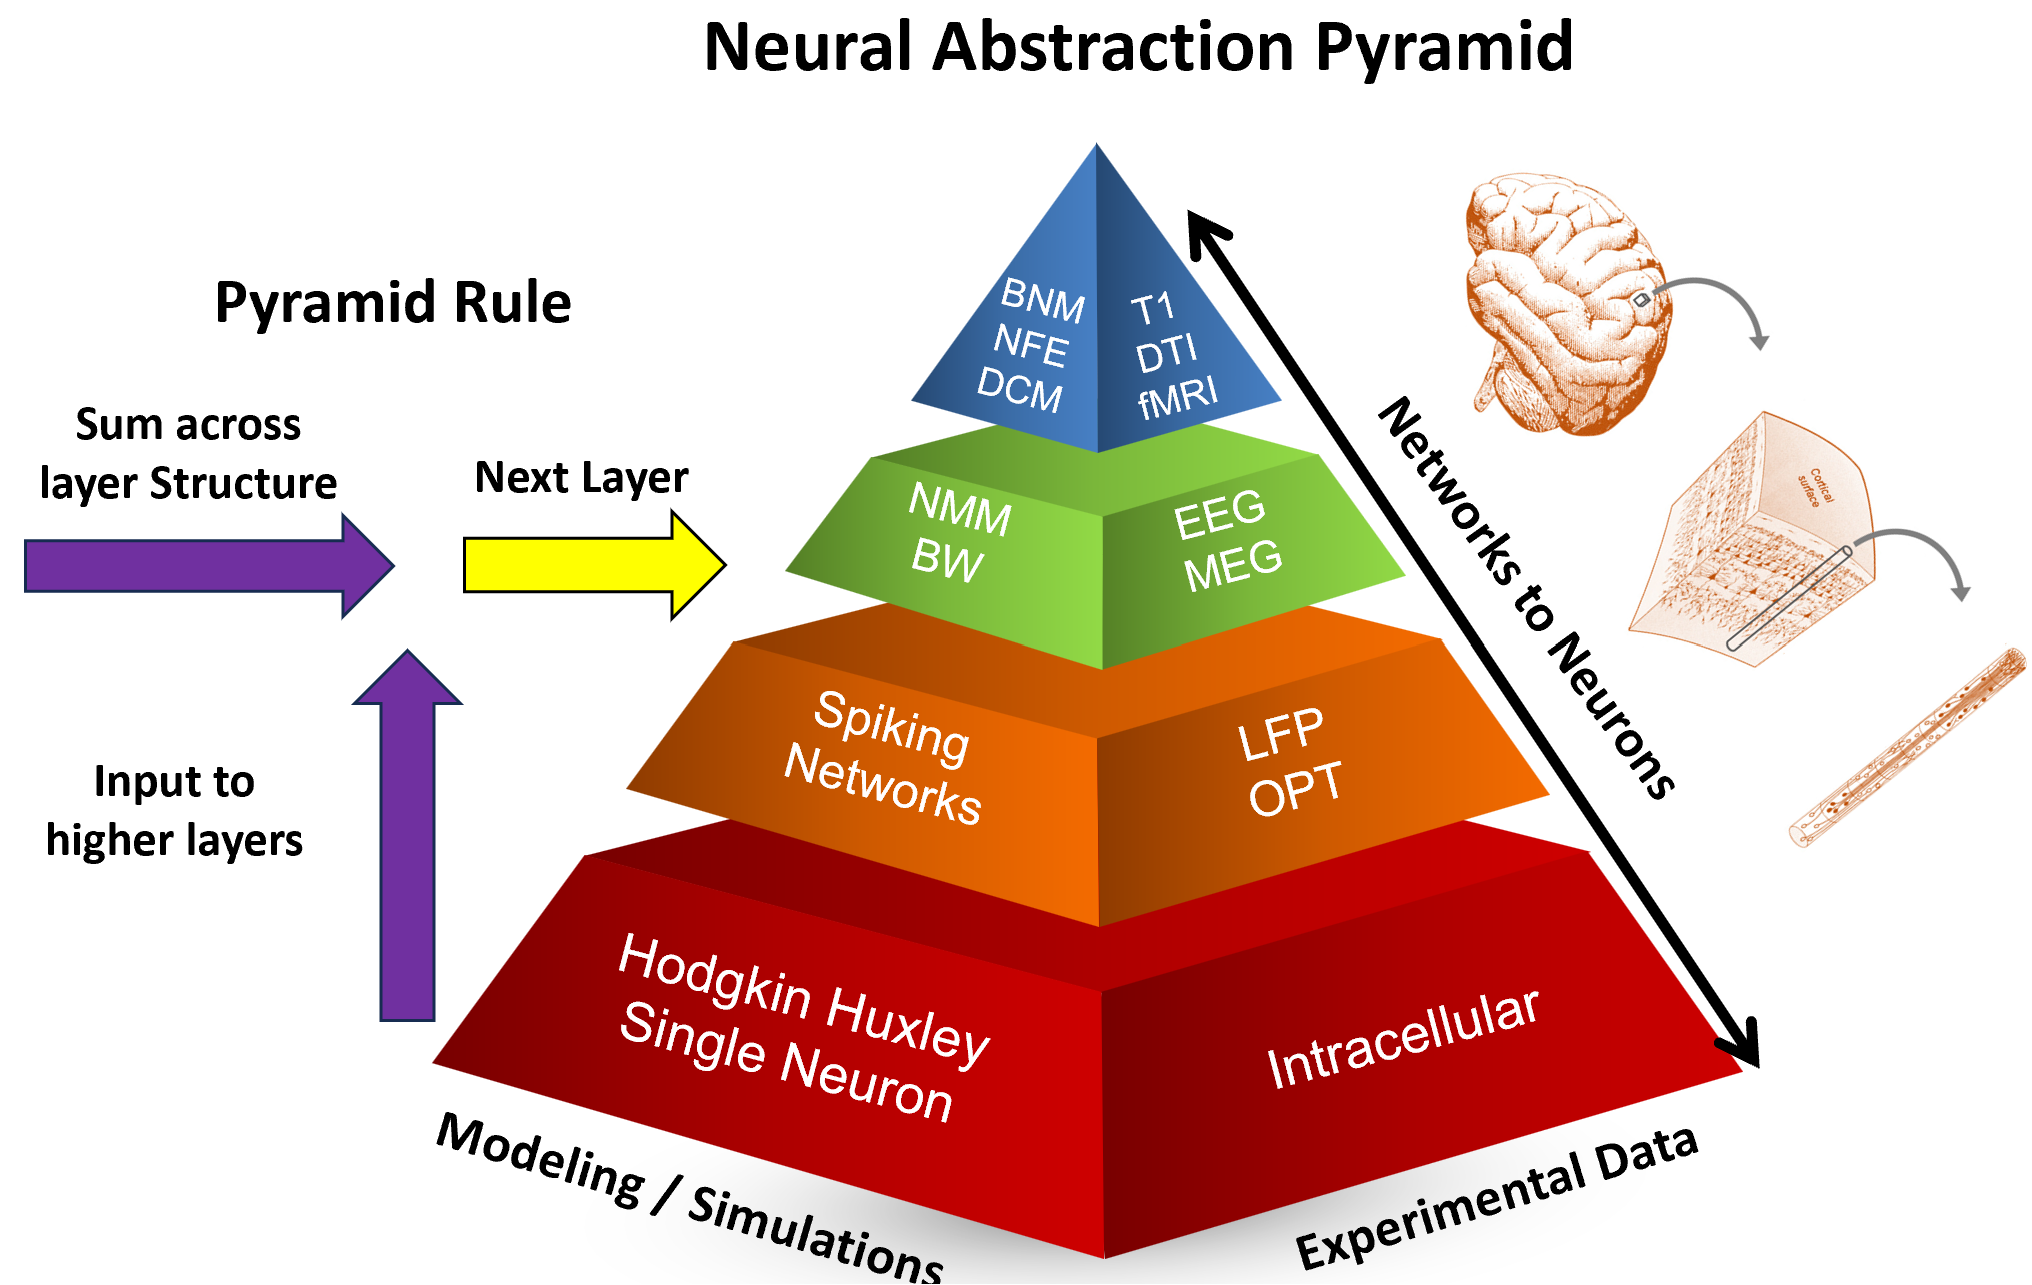

In [2]:
Image(filename='pyramid.png', width=600)

***
$\mathbf{\text{Sparse Identification of Nonlinear Dynamics}}$<br>
***

1.&emsp; Overall Equation of Brain Dynamics $$ \dfrac{dx_i}{dt} (t) = \Lambda(x_i(t)) + F(\sum_{j} SC_{ij}x_{j}(t)) + L(u(t)) + noise $$

2.&emsp; Assume that during resting state fMRI  $$L(u(t)) = 0$$

3.&emsp; The decay rate of the network is set to  $$ \Lambda(x_i(t)) = -k*x_i(t)$$ where k roughly should correspond with the Hemodynamic Response Function decay rate and is around 0.22

4.&emsp; To solve for F we write as product of a libray $\Theta(X)$ and unknown coeffcients $\Xi$: $$ \dot X = F(X) =\Theta(X) *\Xi + \eta Z $$ 

5.&emsp; The library consists of a taylor series expansion of the measurements X $$\Theta(X)  = \begin{bmatrix}
1 & X & X^2 & X^3 & ... X^N    
\end{bmatrix}  $$

6.&emsp; Any activity that is not part of the current activity of the network X, such as $L(u(t))$ is observed as noise $\eta Z $


In [3]:
##### some useful functions


def ctransform(connectome, LUT):
    connectome_out = np.zeros((84,84))

    for i in range(84):
        for j in range(84):
            connectome_out[LUT[i],LUT[j]] = connectome[i, j]

    return connectome_out

def heatPlot(matrix):
    plt.imshow(matrix, cmap='jet',  interpolation='nearest')
    plt.clim([-1,1])

def hemi_corrcoef(m1, m2): 
    m_half = int(n_vox/2)
    m1_ = np.hstack([np.triu(m1[: m_half,: m_half],1).flatten(), np.triu(m1[ m_half:, m_half:],1).flatten(),np.tril(m1[: m_half,: m_half],-1).flatten(), np.tril(m1[: m_half,: m_half],-1).flatten()])
    m2_ = np.hstack([np.triu(m2[: m_half,: m_half],1).flatten(), np.triu(m2[ m_half:, m_half:],1).flatten(),np.tril(m2[: m_half,: m_half],-1).flatten(), np.tril(m2[: m_half,: m_half],-1).flatten()])
    return np.corrcoef(m1_, m2_)[0,1]



def dest_transform(data):
    data_half = np.array(data[:34,:])
    data2_half = np.array(data[34:,:])
    
    data2_flip = data2_half[::-1,:]
    
    return np.vstack([data_half, data2_flip])
    

from scipy.stats import linregress


def coefficient_calc(m1, m2):
    m_half = int(n_vox/2)
    m1_ = np.array(np.hstack([np.triu(m1[:m_half,:m_half],1).flatten(), np.triu(m1[m_half:,m_half:],1).flatten(),np.tril(m1[:m_half,:m_half],-1).flatten(), np.tril(m1[:m_half,:m_half],-1).flatten()]))
    m2_ = np.array(np.hstack([np.triu(m2[:m_half,:m_half],1).flatten(), np.triu(m2[m_half:,m_half:],1).flatten(),np.tril(m2[:m_half,:m_half],-1).flatten(), np.tril(m2[:m_half,:m_half],-1).flatten()]))

    [coefficient,j2,j3,j4,j5]= linregress(m2_, m1_)
    
    return coefficient


def ode_solve_sindy_10(coefficients, degree):
    def solver2(X, t, n):
        result = np.zeros(X.shape[0])
        for i in range(degree):
            result +=  np.matmul(coefficients[:, i*X.shape[0]:(i+1)*X.shape[0]], X**(i+1))
        return n[int(t/0.072)] + result
    
    return solver2



def ode_solve_sindy(coefficients, degree):
    def solver(X, t, n):
        result = np.zeros(X.shape[0])
        for i in range(degree):
            result +=  np.matmul(coefficients[:, i*X.shape[0]:(i+1)*X.shape[0]], X**(i+1))
        return n[int(t/0.72)] + result
    
    return solver



def myfilter(xn, dt):
    n_len = len(xn)

    t = np.linspace(0,(n_len-1)*dt,n_len)

    bfil, afil = signal.butter(3, 0.1)

    zi = signal.lfilter_zi(bfil, afil)
    z, _ = signal.lfilter(bfil, afil, xn, zi=zi*xn[0])
    z2, _ = signal.lfilter(bfil, afil, z, zi=zi*z[0])

    y = signal.filtfilt(bfil, afil, xn)

    return y


import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
def scatter3d(x,y, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig, ax = plt.subplots()
    scatter_c = ax.scatter(x, y, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap, label='Diagonal')
    plt.xlabel('Correlation to SC')
    plt.ylabel('Adjusted R-squared to dynamics')
    plt.title('Pareto Tradeoff between SC and Dynamics')
    fig.patch.set_facecolor('white')
   # fig.savefig('pareto.png', dpi = 200,  bbox_inches='tight')
   # plt.ylim([-0.3,0.25])
    plt.show()
    return scatter_c.get_cmap()
    
    
def simulate_fn(fn, x):
    n_pow = len(fn)
    n_x = len(x)
    out = np.zeros(np.size(x))
    for j in range(n_x):
        out[j] = sum([fn[i]*(x[j]**(i+1)) for i in range(n_pow)])
    return out


def ode_int_der(x, t, der):
    indx = int(t/0.72)
    return der[indx]

In [4]:
#### Names of the cortical brain regions

roi_names = np.genfromtxt('roi_names.txt',dtype='str')
roi_yeo = np.loadtxt('yeo66network.txt')
roi_names_abr = np.genfromtxt('roi_names_abr.txt', dtype = 'str')

fmri_LUT2=np.loadtxt('C:\\Users\\amrit\\Documents\\roi_reorder.txt')


roi_reorder = np.array([roi_names[int(fmri_LUT2[i])-1] for i in range(70)])
roi_yeo_reorder =  np.array([roi_yeo[int(fmri_LUT2[i])-1] for i in range(70)])
roi_abr_reorder =  np.array([roi_names_abr[int(fmri_LUT2[i])-1] for i in range(70)])

for i in range(70):
    roi_reorder[int(fmri_LUT2[i])-1] = roi_names[i]
    roi_yeo_reorder[int(fmri_LUT2[i])-1] = roi_yeo[i]
    roi_abr_reorder[int(fmri_LUT2[i])-1] = roi_names_abr[i]

    
roi_cortical = roi_reorder[:68]
roi_yeo_cortical = roi_yeo_reorder[:68]
roi_abr_cortical = roi_abr_reorder[:68]

#subcortical naming convention is different than cortical, for plotting purposes of using ggseg.
#Trust me I am as annoyed as you are
subcortical_l = ['Left-Accumbens','Left-Amygdala', 'Left-Hippocampus', 'Left-Pallidum','Left-Putamen', 'Left-Caudate', 'Left-Thalamus', 'Left-Cerebellum']
subcortical_r = ['Right-Accumbens','Right-Amygdala', 'Right-Hippocampus', 'Right-Pallidum' ,'Right-Putamen', 'Right-Caudate', 'Right-Thalamus', 'Right-Cerebellum']

roi_all = np.concatenate([subcortical_r[::-1], roi_cortical, subcortical_l])
print(roi_all)


['Right-Cerebellum' 'Right-Thalamus' 'Right-Caudate' 'Right-Putamen'
 'Right-Pallidum' 'Right-Hippocampus' 'Right-Amygdala' 'Right-Accumbens'
 'insula_right' 'entorhinal_right' 'parahippocampal_right'
 'temporalpole_right' 'frontalpole_right' 'fusiform_right'
 'transversetemporal_right' 'lateraloccipital_right'
 'superiorparietal_right' 'inferiortemporal_right'
 'inferiorparietal_right' 'supramarginal_right' 'bankssts_right'
 'middletemporal_right' 'superiortemporal_right' 'postcentral_right'
 'precentral_right' 'caudalmiddlefrontal_right' 'parsopercularis_right'
 'parstriangularis_right' 'rostralmiddlefrontal_right'
 'parsorbitalis_right' 'lateralorbitofrontal_right'
 'caudalanteriorcingulate_right' 'rostralanteriorcingulate_right'
 'superiorfrontal_right' 'medialorbitofrontal_right' 'lingual_right'
 'pericalcarine_right' 'cuneus_right' 'paracentral_right'
 'isthmuscingulate_right' 'precuneus_right' 'posteriorcingulate_right'
 'posteriorcingulate_left' 'precuneus_left' 'isthmuscingula

In [107]:
fmri = np.genfromtxt('C:\\Users\\amrit\\Documents\\volume\\fmrinative10_447_subcortcerb.txt')

In [108]:
n_subj = 447
all_fmri = np.reshape(fmri, [n_subj,8680,84])
LUT = np.genfromtxt('C:\\Users\\amrit\\Documents\\fs_84.txt')


rest = np.zeros((447,84,8680))

for j in range(447):
    for i in range(84):
        rest[j,int(LUT[i]),:] = all_fmri[j,:,i]


    
all_fc = np.stack([np.corrcoef(rest[xx,:,:1200*4]) for xx in range(n_subj)])

avg_fc = np.mean(all_fc, 0)
corrs = [np.corrcoef(avg_fc[9:75,9:75].flatten(), all_fc[xx,9:75,9:75].flatten())[0,1] for xx in range(n_subj)]

Text(0, 0.5, 'Region of Interest')

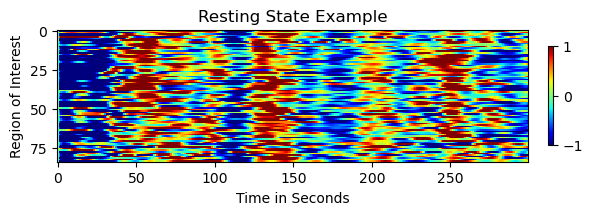

In [7]:
heatPlot(rest[13,:,:300])
plt.colorbar(fraction=0.01, pad=0.04)
plt.title('Resting State Example')
plt.xlabel('Time in Seconds')
plt.ylabel('Region of Interest')

In [8]:

#### Compare with previous publications, in this case from my lab open available data Schirner 2018
import scipy.io
fmri_mat = scipy.io.loadmat('C:\\Users\\amrit\\GDrive\\pythonscripts\\multimodal\\empirical_fMRI.mat')
fmrimc = np.squeeze(fmri_mat['fMRI'])

fmri_LUT= np.loadtxt('C:\\Users\\amrit\\GDrive\\pythonscripts\\LUT\\fmri_deco.txt')

n_subj = 15

t_multiple = []
fmri_multiple = []
dt = 1.94

all_fmrimc = np.zeros([n_subj,661,68])

for i in range(n_subj):
    all_fmrimc[i] = fmrimc[i][0]
    
yero = np.zeros((n_subj, 661))

all_fmrimc = np.insert(all_fmrimc, 3, yero, axis = 2)
all_fmrimc = np.insert(all_fmrimc, 38, yero, axis =2)



restm = np.zeros((n_subj,70,661))

for j in range(n_subj):
    for i in range(69):
        restm[j,int(fmri_LUT[i])-1,:] = np.transpose(all_fmrimc[j,:,i])

        
restm = restm[:,:66,:]
all_fcm = np.stack([np.corrcoef(restm[xx,:,:]) for xx in range(n_subj)])
avg_fcm = np.mean(all_fcm, 0)

corrsm = [np.corrcoef(avg_fcm.flatten(), all_fcm[xx,:,:].flatten())[0,1] for xx in range(15)]


corrsc = [np.corrcoef(avg_fcm.flatten(), all_fc[xx,9:75,9:75].flatten())[0,1] for xx in range(447)]


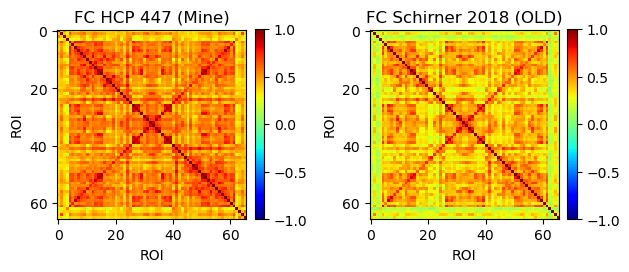

In [109]:
fig , axs = plt.subplots(1,2)


im1= axs[0].imshow(avg_fc[9:75,9:75],cmap='jet',  interpolation='nearest', vmin=-1, vmax=1)
im2= axs[1].imshow(avg_fcm,cmap='jet',  interpolation='nearest', vmin=-1, vmax=1)

axs[0].set_title('FC HCP 447 (Mine)')
axs[1].set_title('FC Schirner 2018 (OLD)')
axs[0].set(xlabel='ROI')
axs[1].set(xlabel='ROI')
axs[0].set(ylabel='ROI')
axs[1].set(ylabel='ROI')

fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()

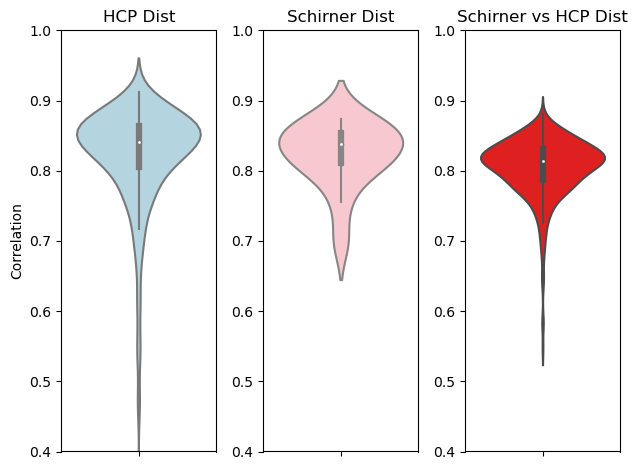

In [110]:
fig ,axes = plt.subplots(1,3)

sns.violinplot(ax=axes[0], y=corrs, orient='v', color='lightblue')
axes[0].set(ylim=(0.4, 1))
axes[0].set(title='HCP Dist')
axes[0].set(ylabel='Correlation')

sns.violinplot(ax=axes[1],y=corrsm, orient='v', color='pink')
axes[1].set(ylim=(0.4, 1))
axes[1].set(title='Schirner Dist')

sns.violinplot(ax=axes[2],y=corrsc, orient='v', color='red')
axes[2].set(ylim=(0.4, 1))
axes[2].set(title='Schirner vs HCP Dist')


fig.tight_layout()
plt.show()

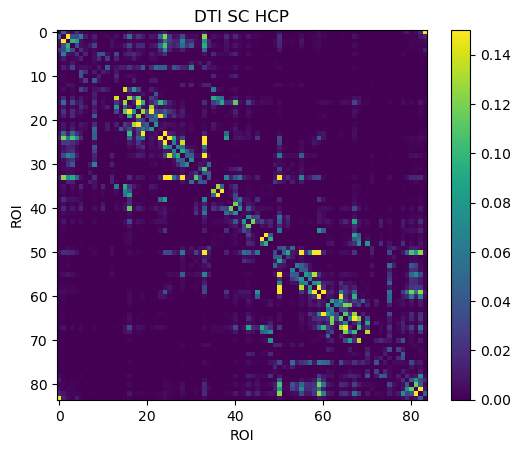

In [11]:
n_dti = 443

all_subj = np.array(np.loadtxt('C:\\Users\\amrit\\Documents\\DTI\\dti_subj.txt'))
all_subj = [str(all_subj[i]) for i in range(n_dti)]


myLUT = np.loadtxt('C:\\Users\\amrit\\Documents\dti_84.txt')
myLUT = [int(myLUT[i]) for i in range(84)]



path = 'C:\\Users\\amrit\\Documents\\DTI\\weight_matrix_noscal_'
n_vox = 84

all_connectomes = np.zeros((n_dti,n_vox,n_vox))

for i in range(n_dti):
    subj_str = path + all_subj[i][:6] + ".csv"
    a_connectome = ctransform(np.loadtxt(subj_str), myLUT)
    all_connectomes[i,:,:] = a_connectome


norm_connectomes = np.zeros((n_dti,n_vox,n_vox))
for i in range(n_dti):
    w,u = LA.eig(all_connectomes[i])
    norm_connectomes[i] = (1/w[0])*all_connectomes[i]

avg_connectome = np.sum(norm_connectomes, 0)/n_dti

sim_connectome = avg_connectome - np.eye(n_vox)
plt.imshow(avg_connectome)
plt.clim(0,0.15)
plt.title('DTI SC HCP')
plt.colorbar()
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.savefig('dti.png')

In [12]:
#Splitting the HCP data into Rest and Task subsets and test and train datasets
#both Rest and Task

dt = 0.72
splits = [1200, 1200, 1200, 1200, 176, 176, 253, 253, 284, 284, 232, 232, 274, 274, 405, 405, 316, 316]


n_splits = len(splits)

all_multiple = []
t_multiple = []
for i in range(397):
    start = 0
    for j in range(18):    
        all_multiple.append(np.transpose(rest[i,:,start:start+splits[j]]))
        t_multiple.append(np.arange(0, splits[j] * dt, dt))
        
        start= start + splits[j]

test_multiple = []
t_test_multiple = []
for i in range(50):
    start = 0
    for j in range(18):    
        test_multiple.append(np.transpose(rest[i+397,:,start:start+splits[j]]))
        t_test_multiple.append(np.arange(0, splits[j] * dt, dt))
        
        start= start + splits[j]

In [13]:
#Rest only dataset
dt = 0.72
splits = [1200, 1200, 1200, 1200, 176, 176, 253, 253, 284, 284, 232, 232, 274, 274, 405, 405, 316, 316]


n_splits = len(splits)

rest_only = []
t_multiple_only = []
for i in range(397):
    start = 0
    for j in range(4):    
        rest_only.append(np.transpose(rest[i,:,start:start+splits[j]]))
        t_multiple_only.append(np.arange(0, splits[j] * dt, dt))
        
        start= start + splits[j]

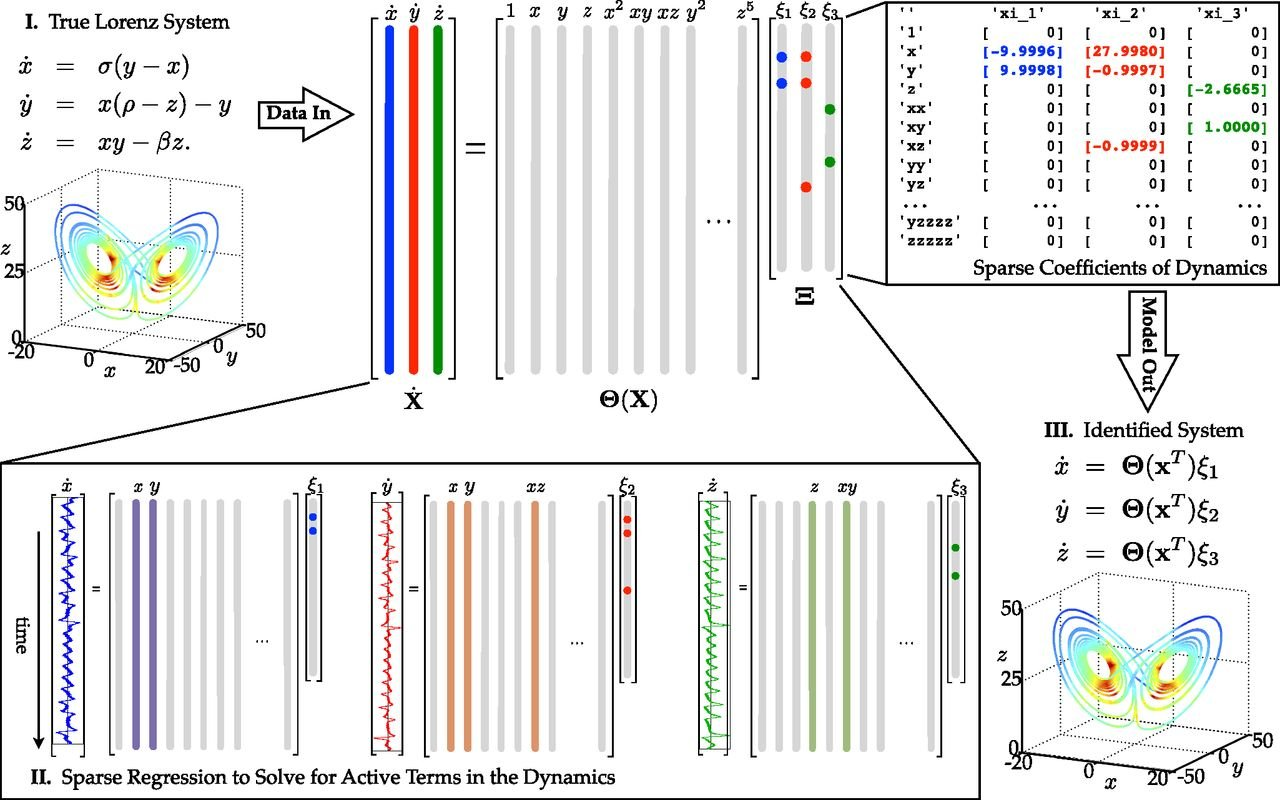

In [14]:
Image(filename='SINDydiagram.jpeg') 

In [114]:
library = ps.PolynomialLibrary(include_bias = False,include_interaction=False, degree=7)
library.fit(np.transpose(rest[1]))



n_vox = 84
#contraints
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())


lhs = np.zeros((n_vox, n_vox * n_features))

for i in range(n_vox):
    lhs[i, i+i*n_features]=1


specialk = 23.333333333333336
specialn = 0.10555555555555556

rhs = np.array([-0.125*specialk*specialn for ll in range(n_vox)])

diffrentiator =  ps.SINDyDerivative(kind='spectral',  drop_endpoints=True)
optimizer = ps.ConstrainedSR3(constraint_rhs=rhs, constraint_lhs=lhs, threshold=8/(specialk), nu=10, thresholder= "l2")
model = ps.SINDy(optimizer=optimizer, feature_library=library, differentiation_method= diffrentiator)
model.fit( rest_only, t=t_multiple_only, multiple_trajectories = True)

a = model.coefficients()

Features (588): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x0^2', 'x1^2', 'x2^2', 'x3^2', 'x4^2', 'x5^2', 'x6^2', 'x7^2', 'x8^2', 'x9^2', 'x10^2', 'x11^2', 'x12^2', 'x13^2', 'x14^2', 'x15^2', 'x16^2', 'x17^2', 'x18^2', 'x19^2', 'x20^2', 'x21^2', 'x22^2', 'x23^2', 'x24^2', 'x25^2', 'x26^2', 'x27^2', 'x28^2', 'x29^2', 'x30^2', 'x31^2', 'x32^2', 'x33^2', 'x34^2', 'x35^2', 'x36^2', 'x37^2', 'x38^2', 'x39^2', 'x40^2', 'x41^2', 'x42^2', 'x43^2', 'x44^2', 'x45^2', '

In [16]:
n_dti = 443
n_vox = 84


def sc_calc(connectomes, w, n_dti):
    c = np.zeros((n_dti))
    c_90 = np.zeros((n_dti))
    c_mag = np.zeros((n_dti))
    for i in range(n_dti):
        mat = connectomes[i]
        c[i] = hemi_corrcoef(w, mat)
        c_90[i] = hemi_corrcoef(np.rot90(w), np.rot90(mat))
        c_mag[i] = coefficient_calc(w, mat)
    
    return [c, c_90, c_mag]
        
w1 = np.array(a[:,:n_vox])
w2 = np.array(a[:,n_vox:n_vox*2])
w3 = np.array(a[:,n_vox*2:n_vox*3])
w4 = np.array(a[:,n_vox*3:n_vox*4])
w5 = np.array(a[:,n_vox*4:n_vox*5])
w6 = np.array(a[:,n_vox*5:n_vox*6])
w7 = np.array(a[:,n_vox*6:n_vox*7])

[corr1, corr1h, corrc1] = sc_calc(all_connectomes,  w1, n_dti)        
[corr2, corr2h, corrc2] = sc_calc(all_connectomes,  w2, n_dti)        
[corr3, corr3h, corrc3] = sc_calc(all_connectomes,  w3, n_dti)        
[corr4, corr4h, corrc4] = sc_calc(all_connectomes,  w4, n_dti)        
[corr5, corr5h, corrc5] = sc_calc(all_connectomes,  w5, n_dti)        
[corr6, corr6h, corrc6] = sc_calc(all_connectomes,  w6, n_dti)        
[corr7, corr7h, corrc7] = sc_calc(all_connectomes,  w7, n_dti)        



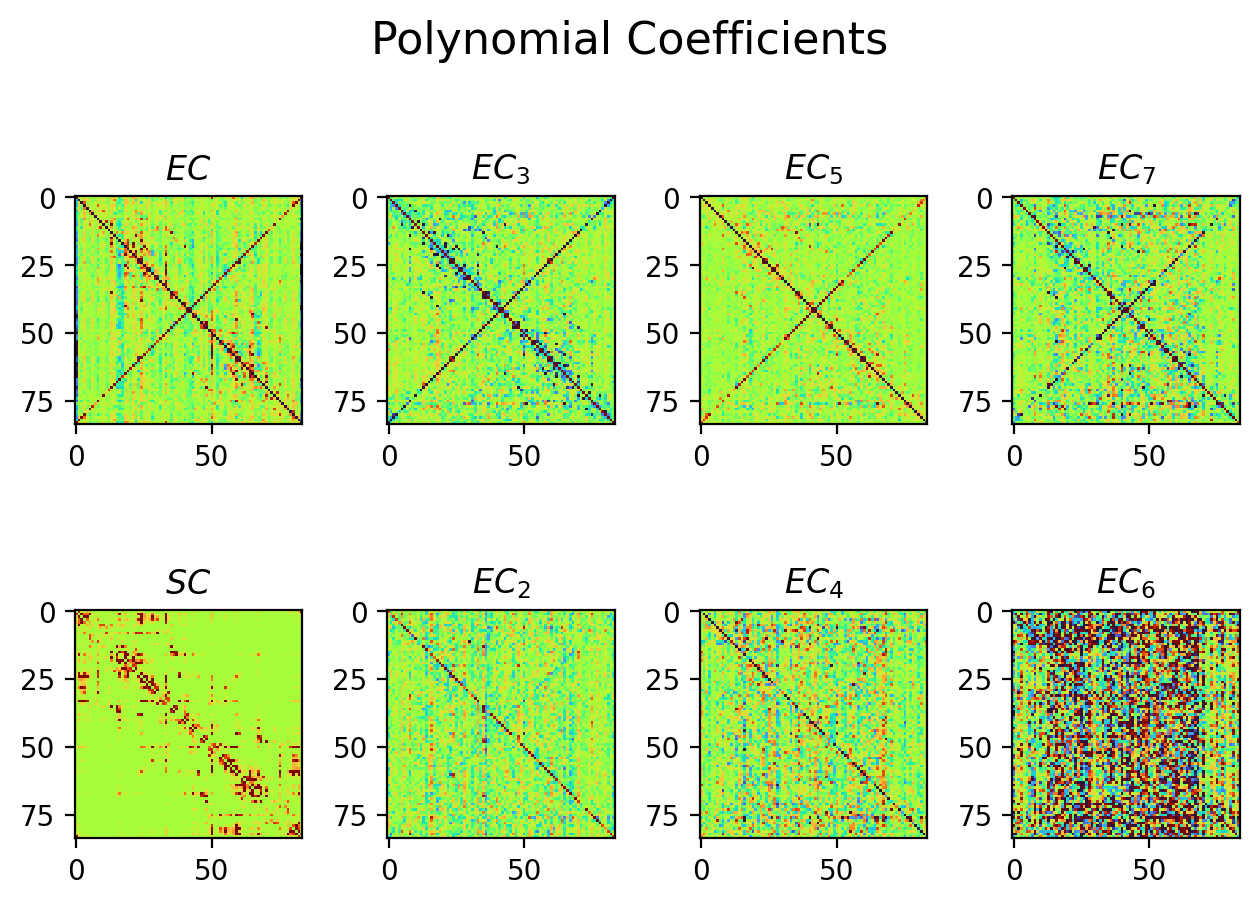

In [17]:
plt.rcParams['figure.dpi'] = 200
fig, axs = plt.subplots(2,4)

kn = 0.6


im1= axs[1,0].imshow(avg_connectome,cmap='turbo',  interpolation='nearest', vmin=-0.1*kn , vmax=0.1*kn)
im2= axs[0,0].imshow(w1,cmap='turbo',  interpolation='nearest', vmin=-0.1*kn, vmax=0.1*kn)


im3= axs[1,1].imshow(w2,cmap='turbo',  interpolation='nearest', vmin=-0.01*kn, vmax=0.01*kn)
im4= axs[0,1].imshow(w3,cmap='turbo',  interpolation='nearest', vmin=-0.01*kn, vmax=0.01*kn)


im5= axs[1,2].imshow(w4,cmap='turbo',  interpolation='nearest', vmin=-0.001*kn, vmax=0.001*kn)
im6= axs[0,2].imshow(w5,cmap='turbo',  interpolation='nearest', vmin=-0.001*kn, vmax=0.001*kn)



im7= axs[1,3].imshow(w6,cmap='turbo',  interpolation='nearest', vmin=-0.00001*kn, vmax=0.00001*kn)
im8= axs[0,3].imshow(w7,cmap='turbo',  interpolation='nearest', vmin=-0.00001*kn, vmax=0.00001*kn)




for b in range(2):
    for c in range(4):
        axh = axs[b,c]
        #axh.set(xlabel='ROI')
        #axh.set(ylabel='ROI')
        

axs[1,0].set_title('$SC$')
axs[0,0].set_title('$EC$')

axs[1,1].set_title('$EC_{2}$')
axs[0,1].set_title('$EC_{3}$')

axs[1,2].set_title('$EC_{4}$')
axs[0,2].set_title('$EC_{5}$')

axs[1,3].set_title('$EC_{6}$')
axs[0,3].set_title('$EC_{7}$')

#fig.colorbar(im5, axs[1,2], fraction=0.046, pad=0.04)
#fig.colorbar(im6, axs[0,2], fraction=0.046, pad=0.04)
#fig.colorbar(im7, axs[1,3], fraction=0.046, pad=0.04)
#fig.colorbar(im8, axs[0,3], fraction=0.046, pad=0.04)


fig.suptitle('Polynomial Coefficients', fontsize=16)
fig.tight_layout()
plt.show()

plt.style.use('default')


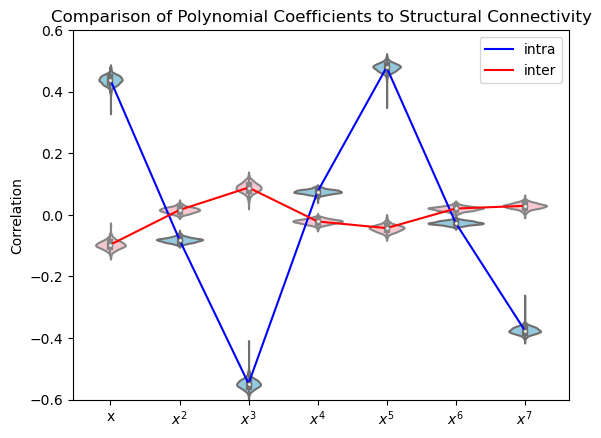

In [18]:
corr_all = np.zeros((n_dti,7))

corr_all[:,0] = corr1
corr_all[:,1] = corr2
corr_all[:,2] = corr3
corr_all[:,3] = corr4
corr_all[:,4] = corr5
corr_all[:,5] = corr6
corr_all[:,6] = corr7


corr_allh = np.zeros((n_dti,7))

corr_allh[:,0] = corr1h
corr_allh[:,1] = corr2h
corr_allh[:,2] = corr3h
corr_allh[:,3] = corr4h
corr_allh[:,4] = corr5h
corr_allh[:,5] = corr6h
corr_allh[:,6] = corr7h

df = pd.DataFrame({"$x$": corr1,
                    "$x^{2}$" : corr2,
                    "$x^{3}$" : corr3,
                    "$x^{4}$" : corr4,
                    "$x^{5}$" : corr5,
                    "$x^{6}$" : corr6,
                    "$x^{7}$" : corr7,

})




df2 = pd.DataFrame({"x": corr1h,
                    "$x^{2}$" : corr2h,
                    "$x^{3}$" : corr3h,
                    "$x^{4}$" : corr4h,
                    "$x^{5}$" : corr5h,
                    "$x^{6}$" : corr6h,
                    "$x^{7}$" : corr7h,

})

plt.figure()

sns.violinplot(data = df, color="skyblue")

sns.violinplot(data = df2, color="pink")
plt.plot(np.mean(corr_all,0),color="blue" , label= 'intra')
plt.plot(np.mean(corr_allh,0),color="red" , label= 'inter')

plt.legend()


plt.title("Comparison of Polynomial Coefficients to Structural Connectivity")
plt.ylabel("Correlation")

fig.patch.set_facecolor('white')

#plt.savefig('Polynomailcoef.png')
plt.ylim([-0.6,0.6])
plt.show()


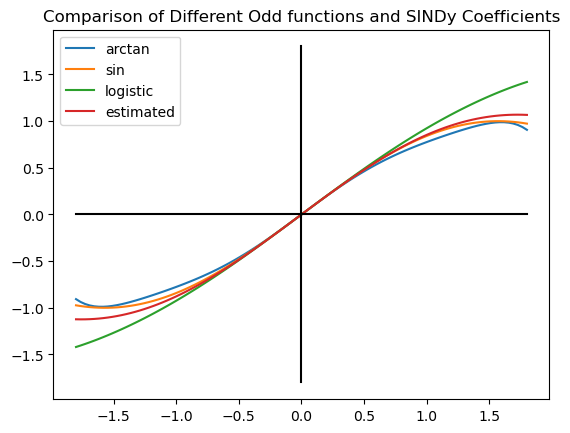

In [19]:
poly= np.array([np.mean(corrc1), np.mean(corrc2), np.mean(corrc3), np.mean(corrc4), np.mean(corrc5), np.mean(corrc6), np.mean(corrc7)])
yyyy= poly/np.mean(corrc1)

tanh_c = np.array([1, 0, -1/3, 0, 2/15, 0, -68/2835])
sin_c = np.array([1, 0, -1/6, 0, 1/120, 0, -1/5040])
errf = np.array([ 2/np.sqrt(np.pi),0, -2/(3*np.sqrt(np.pi)), 0, 1/(5*np.sqrt(np.pi)), -1/(21*np.sqrt(np.pi)) ])
logistic = [2/2, 0, -2/24, 0, 2/240, 0, -34/40320]

xxx = np.linspace(-1.8, 1.8, num=100)


tanh_y= simulate_fn(tanh_c, xxx)
sin_y = simulate_fn(sin_c, xxx)
errf_y = simulate_fn(sin_c, xxx)
log_y = simulate_fn(logistic, xxx)
real_y = simulate_fn(yyyy, xxx)

x_axis = np.zeros(np.shape(xxx))


plt.plot( xxx, tanh_y, label="arctan")
plt.plot( xxx, sin_y,  label="sin")
#plt.plot( xxx, errf_y)
plt.plot(xxx, log_y, label='logistic')
plt.plot(xxx, real_y, label='estimated')
plt.plot(xxx, x_axis, 'k')
plt.plot(x_axis, xxx, 'k')
plt.legend()
plt.title('Comparison of Different Odd functions and SINDy Coefficients')
plt.savefig('sigmoidal')


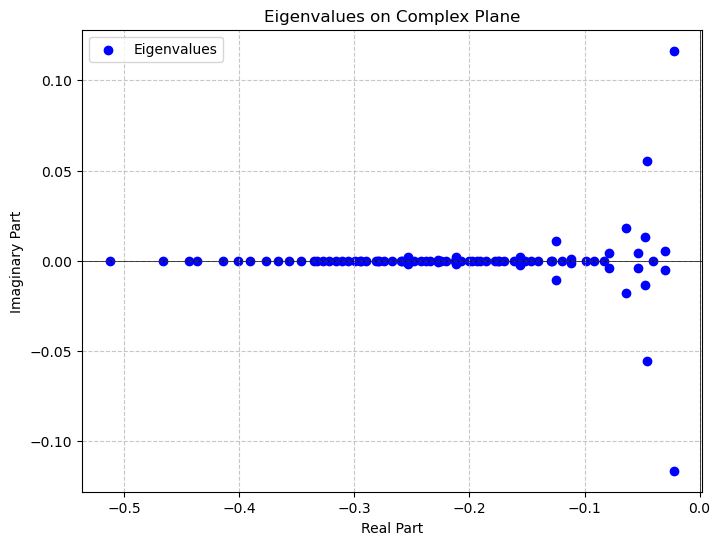

In [20]:
####Eigenvalue stuff


#plt.imshow(w1,cmap='turbo',  interpolation='nearest', vmin=-0.1*kn, vmax=0.1*kn)


eigenValues, eigenVectors = np.linalg.eig(w1)

idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

# Extract real and imaginary parts of eigenvalues
real_parts = np.real(eigenValues)
imaginary_parts = np.imag(eigenValues)

# Create a complex plane plot
plt.figure(figsize=(8, 6))
plt.scatter(real_parts, imaginary_parts, c='blue', marker='o', label='Eigenvalues')
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalues on Complex Plane')
plt.legend()
plt.show()

Text(0.5, 0, 'Sorted by Largest Eigenvalue')

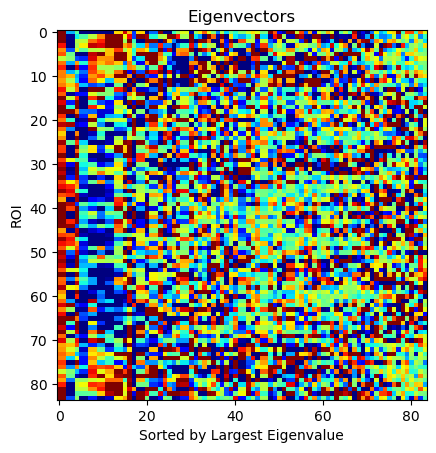

In [21]:
heatPlot(np.real(eigenVectors))
plt.clim([-0.1,0.1])
plt.title('Eigenvectors')
plt.ylabel('ROI')
plt.xlabel('Sorted by Largest Eigenvalue')

C:\Users\amrit\AppData\Local\Temp\ipykernel_30168\3961126336.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  sym[i] = np.corrcoef(eigenVectors[:42,i], np.flip(eigenVectors[42:,i],0))[0,1]


Text(0.5, 0, 'Sorted by Largest Eigenvalue')

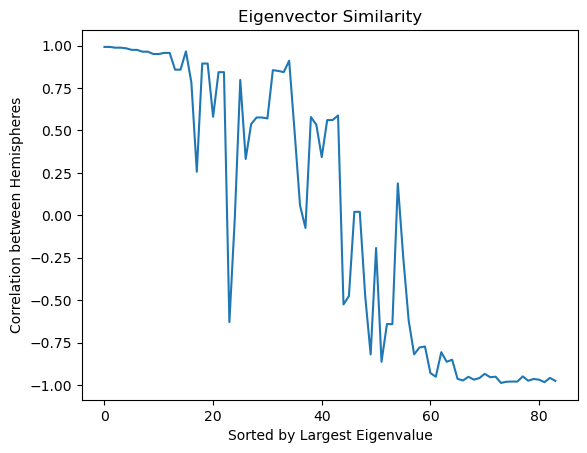

In [22]:
sym = np.zeros((84,))

for i in range(84):

    sym[i] = np.corrcoef(eigenVectors[:42,i], np.flip(eigenVectors[42:,i],0))[0,1]
    
plt.plot(sym)
plt.title('Eigenvector Similarity')
plt.ylabel('Correlation between Hemispheres')
plt.xlabel('Sorted by Largest Eigenvalue')

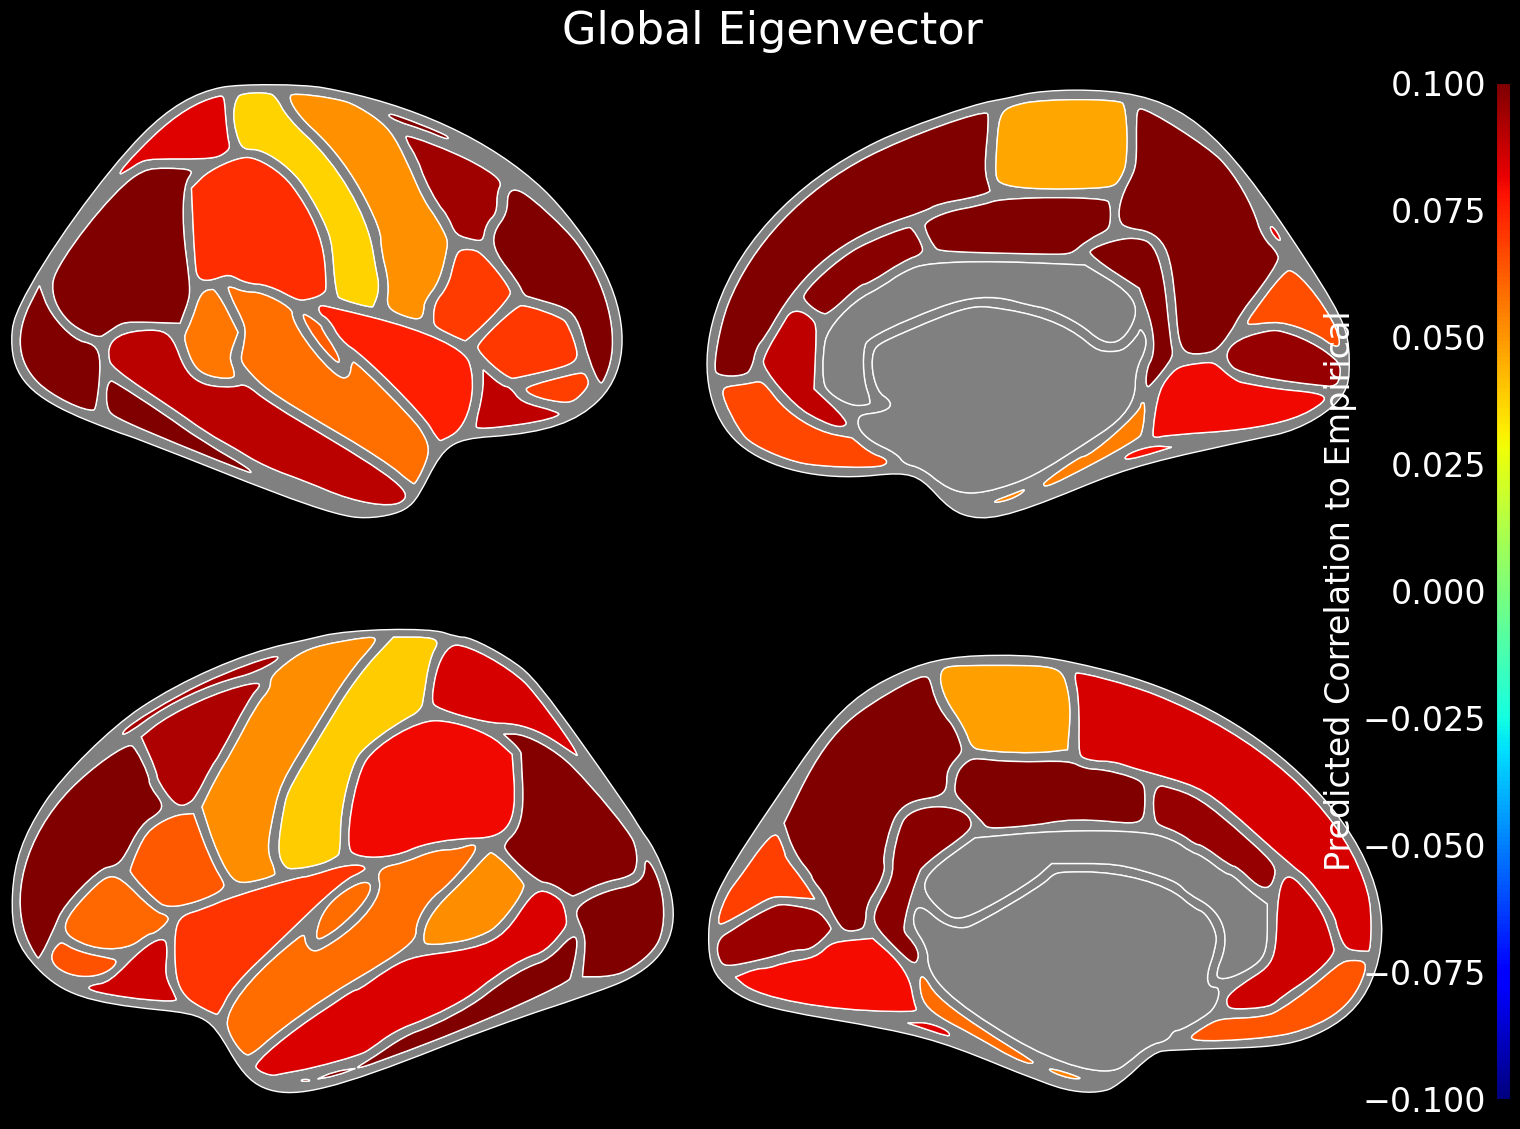

In [23]:

toPlot = eigenVectors[8:76,0]

data = {(roi_cortical[i]) : np.real(toPlot[i])
        for i in range(68)}


ggseg.plot_dk(data, background='black', edgecolor='w', cmap='jet', vminmax = [-0.1,0.1],
              bordercolor='gray', ylabel='Predicted Correlation to Empirical', title='Global Eigenvector', fontsize =32)


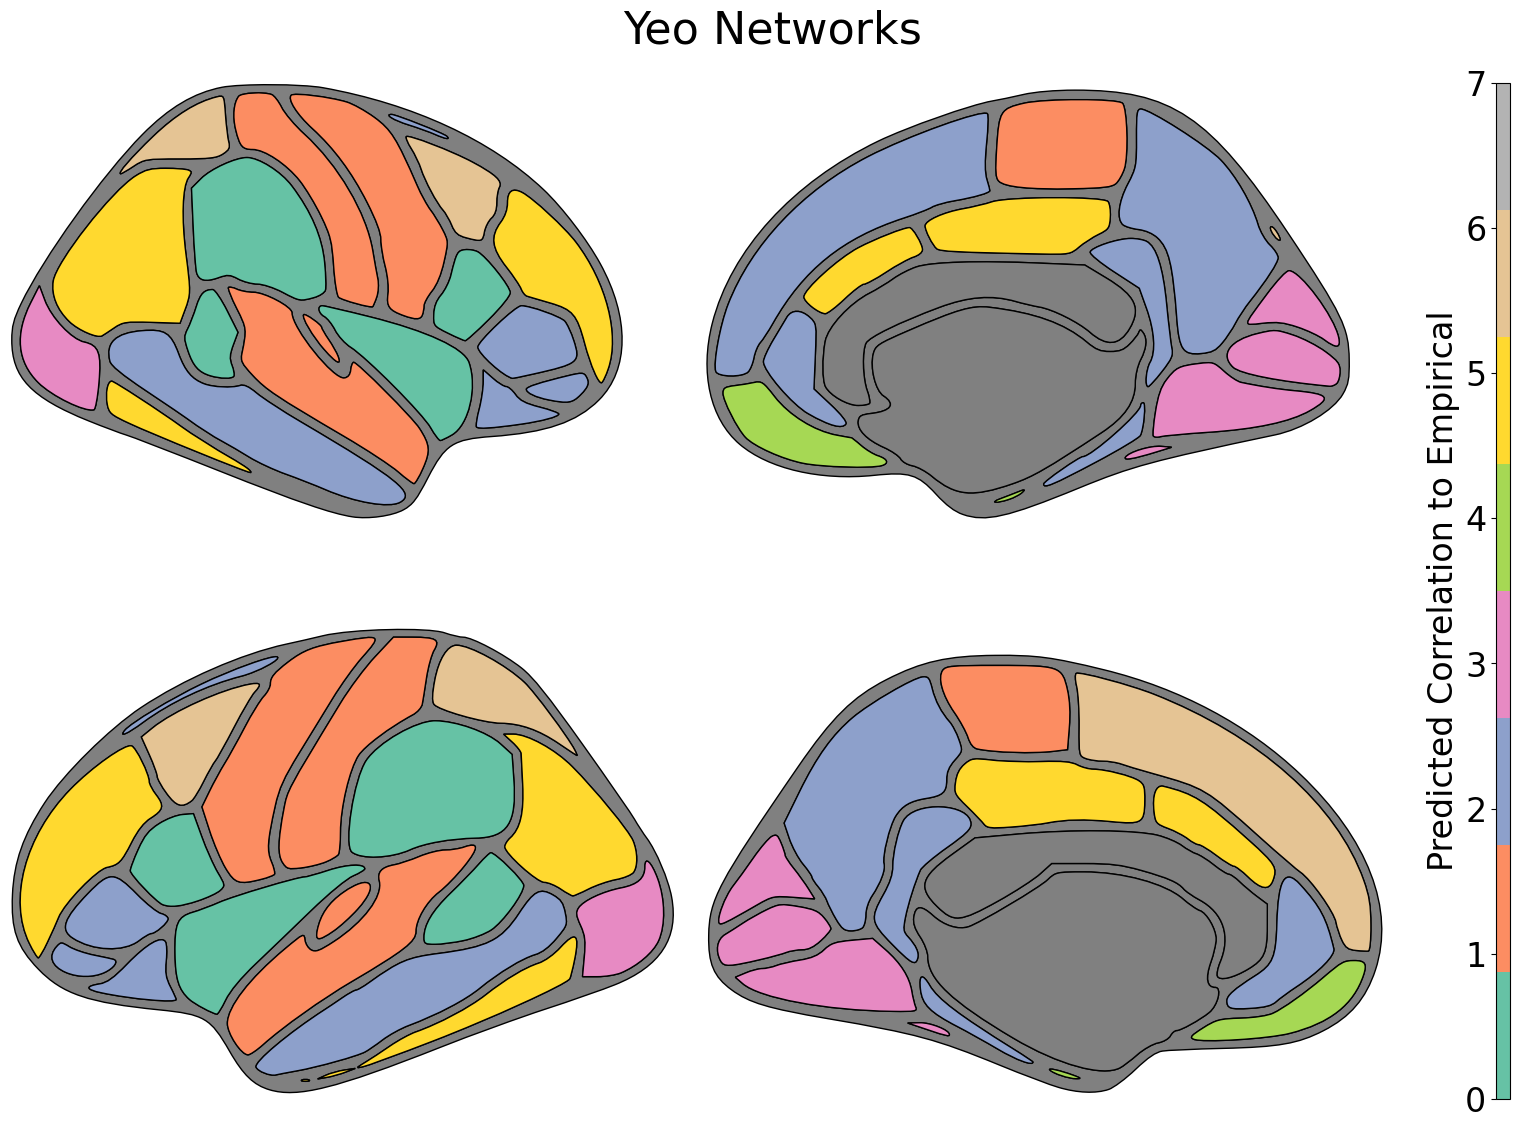

In [88]:


data = {(roi_cortical[i]) : int(roi_yeo_cortical[i]) -1 
        for i in range(68)}


ggseg.plot_dk(data, background='white', edgecolor='k', cmap='Set2', vminmax = [0,7],
              bordercolor='gray', ylabel='Predicted Correlation to Empirical', title='Yeo Networks', fontsize =32)


In [89]:
def ctransformhalf(connectome, LUT):
    connectome_out = np.zeros((34,34))

    for i in range(34):
        for j in range(34):
            connectome_out[LUT[i],LUT[j]] = connectome[i, j]

    return connectome_out

def threshold_sc(mat, thr):
    thr_sc = np.zeros((34,34))
    
    n_edges = int(np.round((1-thr)*34*34))
    st = np.array(np.sort(mat.flatten()))
    mythr = st[n_edges]
    
    for i in range(34):
        for j in range(34):
            if (mat[i,j] > mythr):
                thr_sc[i,j] = mat[i,j]
            else:
                thr_sc[i,j] = np.nan
    return thr_sc




new_reorder = np.argsort(roi_yeo_cortical[:34])
yeo_re = roi_yeo_cortical[new_reorder]
sc_re = ctransformhalf(avg_connectome[8:42,8:42], new_reorder)
sc_re_w = ctransformhalf(w1[8:42,8:42], new_reorder)


thr_sc = threshold_sc(sc_re, 0.15)
thr_w1 = threshold_sc(sc_re_w, 0.15)



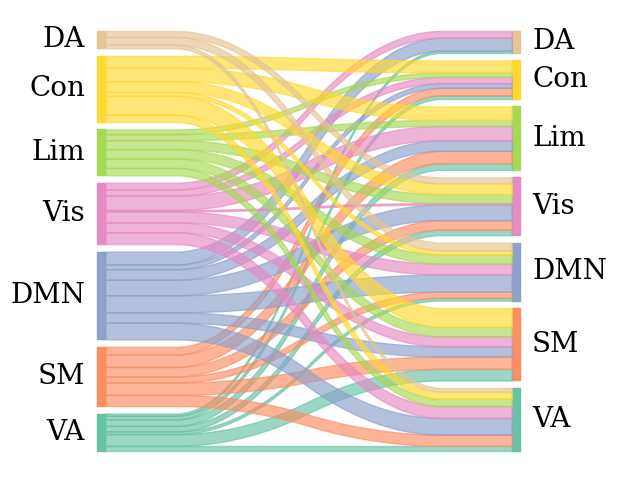

In [90]:
from pySankey.sankey import sankey
#note I had to modify the pySankey package as there was a bug 
# it should be len(labels) > 0 not len(labels > 0)
import matplotlib.cm as cm 

networks = ["VA", "SM", "DMN", "Vis", "Lim", "Con", "DA"]

lsts_tr = []
lsts_rc = []
lsts_w = []


set3_5 = cm.get_cmap("Set2", lut = 8)

set3_5(0)


colors = {
    "VA": set3_5(0),
    "SM": set3_5(0.13),
    "DMN":set3_5(0.26),
    "Vis": set3_5(0.38),
    "Lim": set3_5(0.51),
    "Con": set3_5(0.64),
    "DA": set3_5(0.78)
}


for i_x in range(34):
    for j_x in range(34):
        if(~np.isnan(thr_w1[i_x, j_x])):
            lsts_tr.append(networks[ int(yeo_re[i_x] - 1)])
            lsts_rc.append(networks[ int(yeo_re[j_x] - 1)])
            lsts_w.append(thr_w1[i_x, j_x])
            
sankey(
    left= lsts_tr, right= lsts_rc, 
    leftWeight= lsts_w, rightWeight= lsts_w, leftLabels=networks, rightLabels=networks, 
    aspect=20, fontsize=20, colorDict=colors
)


plt.savefig('sankeyEstimated.png', dpi = 1000)

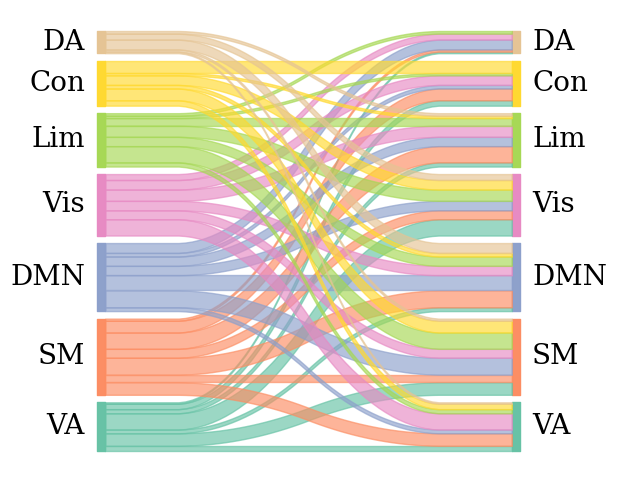

In [91]:
lsts_tr = []
lsts_rc = []
lsts_w = []

colors = {
    "VA": set3_5(0),
    "SM": set3_5(0.13),
    "DMN":set3_5(0.26),
    "Vis": set3_5(0.38),
    "Lim": set3_5(0.51),
    "Con": set3_5(0.64),
    "DA": set3_5(0.78)
}

for i_x in range(34):
    for j_x in range(34):
        if(~np.isnan(thr_sc[i_x, j_x])):
            lsts_tr.append(networks[ int(yeo_re[i_x] - 1)])
            lsts_rc.append(networks[ int(yeo_re[j_x] - 1)])
            lsts_w.append(thr_sc[i_x, j_x])
            
sankey(
    left= lsts_tr, right= lsts_rc, 
    leftWeight= lsts_w, rightWeight= lsts_w, leftLabels=networks, rightLabels=networks,
    aspect=20, fontsize=20, colorDict=colors
)
plt.savefig('sankeyOriginal.png', dpi = 1000)

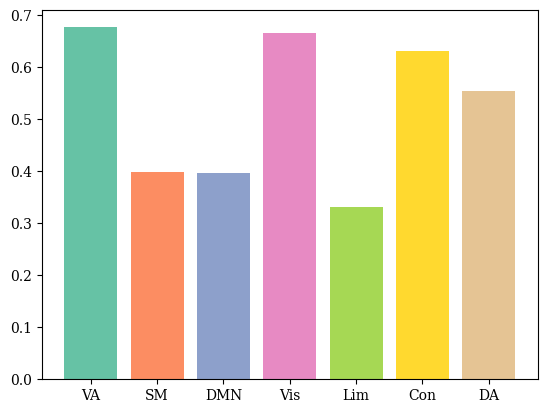

In [92]:

d = np.average(np.diag(sc_re_w))
sc_re_wd = sc_re_w + (-d)*np.eye(34)

corrs = np.zeros((7,))

colors = [set3_5(0), set3_5(0.13), set3_5(0.26), set3_5(0.38), set3_5(0.51),set3_5(0.64),set3_5(0.78)]

for i in range(1,8):
    inx = np.argwhere(yeo_re == i)
    corrs[i-1] = np.corrcoef(sc_re[inx,:].flatten(), sc_re_wd[inx,:].flatten())[0,1]

    
plt.bar( networks, corrs, color=colors)
plt.savefig('CorrelationYeo.png', dpi = 1000)

In [115]:
n_time = 1200

corr_vals_int = np.squeeze(np.zeros((40,)))
tr = 0.72


ts = np.linspace(0.0, tr*n_time, n_time+1)
ode_fn = ode_solve_sindy(np.array(model.coefficients()), 7)

cor = np.zeros((40, n_vox, n_vox))

for j in range(40):
    init_cond = np.random.normal(0, 0.1, n_vox)
    noise = np.random.normal(0, 0.13, (n_time*5)*n_vox)
    noise = np.reshape(noise, [n_time*5,n_vox])

    s = np.array(odeint(ode_fn, init_cond, ts, args=(np.array(noise),)))
    full_sig = np.array([stats.zscore(myfilter(s[:,i], 0.72)) for i in range(n_vox)])

    cor[j] = np.corrcoef(full_sig)


    corr_vals_int[j] = np.corrcoef(avg_fc.flatten(), cor[j].flatten())[0,1]


C:\Users\amrit\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


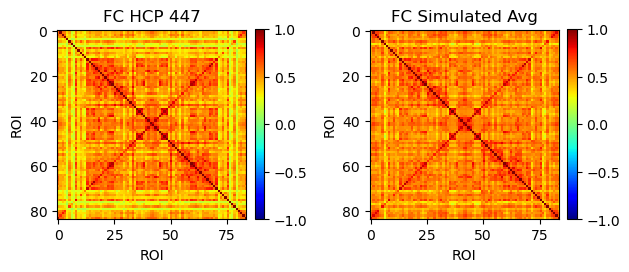

In [116]:
fig , axs = plt.subplots(1,2)


im1= axs[0].imshow(avg_fc,cmap='jet',  interpolation='nearest', vmin=-1, vmax=1)
im2= axs[1].imshow(np.mean(cor, 0),cmap='jet',  interpolation='nearest', vmin=-1, vmax=1)

axs[0].set_title('FC HCP 447')
axs[1].set_title('FC Simulated Avg')
axs[0].set(xlabel='ROI')
axs[1].set(xlabel='ROI')
axs[0].set(ylabel='ROI')
axs[1].set(ylabel='ROI')

fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
fig.tight_layout()

plt.savefig('FC_comp.png')
plt.show()

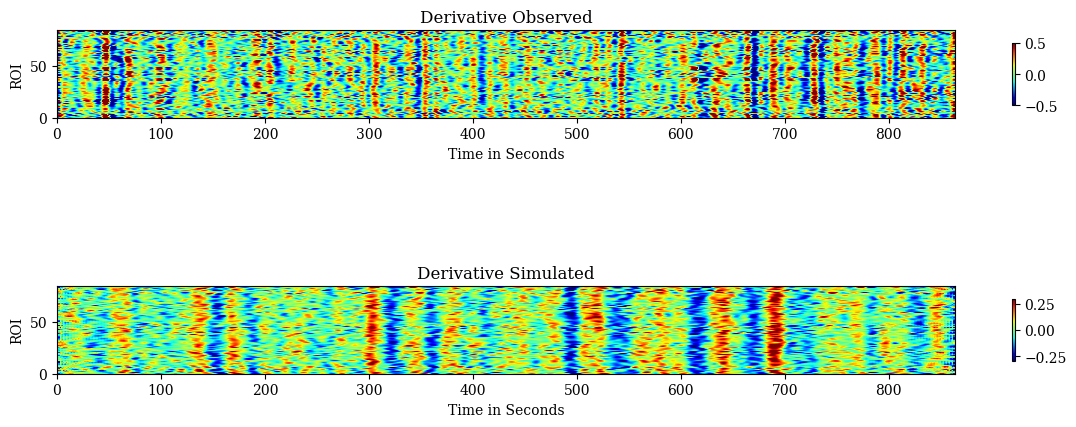

In [97]:



diff_sim = model.differentiate(np.transpose(full_sig[:,:1200]), t_multiple[0])
diff_comp = model.differentiate(rest_only[0], t_multiple[0])



fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12, 6])

# First subplot
ax1 = axes[0]
ax1.set_title("Derivative Observed")
im1 = ax1.imshow(np.transpose(diff_comp), cmap='jet', clim=(-0.5, 0.5), extent=[0, 1200*0.72, 0, 84])
fig.colorbar(im1, ax=ax1, shrink=0.2)
ax1.set_xlabel('Time in Seconds')
ax1.set_ylabel('ROI')

# Second subplot
ax2 = axes[1]
ax2.set_title("Derivative Simulated")
im2 = ax2.imshow(np.transpose(diff_sim), cmap='jet', clim=(-0.3, 0.3), extent=[0, 1200*0.72, 0, 84])
fig.colorbar(im2, ax=ax2, shrink=0.2)
ax2.set_xlabel('Time in Seconds')
ax2.set_ylabel('ROI')
fig.tight_layout()



Text(0, 0.5, 'Correlation')

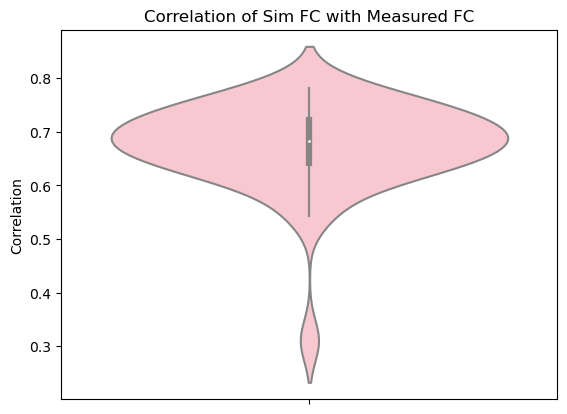

In [117]:
sns.violinplot(y=corr_vals_int, orient='v', color='pink')
plt.title("Correlation of Sim FC with Measured FC")
plt.ylabel("Correlation")

In [101]:
from scipy import integrate
from joblib import Parallel, delayed
from scipy.signal import medfilt


[nxn, nyn, nzn] = np.shape(rest_only)
r_array = np.array(rest_only)

##### Integrate at a tenth of the dt with a traingle impulse response
ode_fn = ode_solve_sindy_10(a, 7)

dt =0.72

all_hrfs = np.zeros((501, n_vox))


init = 0
margin = 0.001

hrf=np.loadtxt('hrf.txt')
hrf_t = 0.72*np.linspace(1, 45, 45) -0.72  

def lets_int(odefn_, init_one_, t_axis_, ip_):
    return odeint(odefn_, init_one_, t_axis_, args=(ip_,))

for vx in range(n_vox):
    count= 0
    init_pts = []
    for i in range(nxn):
        for j in range(1200):
            if np.abs(r_array[i,j,vx] - init) < margin:
                init_pts.append(r_array[i,j,:])
                count = count + 1
        
        if count > 100:
            break
    ip = np.zeros((20000,n_vox))
    t_axis = np.arange(0, 500 * dt/10, dt/10)

    ip[0:35,vx]  = np.array([0.008*x for x in range(35)])
    ip[35:70,vx] = [0.008*(35-x) for x in range(35)]


    
    trajectories = np.stack(Parallel(n_jobs=-1)(delayed(lets_int)(ode_fn, init_, t_axis, ip) for init_ in init_pts))
    all_hrfs[:,vx] = np.median(trajectories, axis = 0)[:,vx]


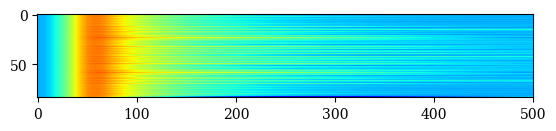

In [102]:
heatPlot(np.transpose(all_hrfs))
plt.clim([-0.3,0.7])

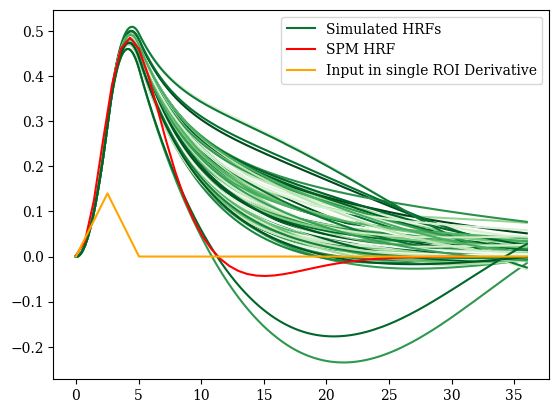

In [103]:
from scipy.signal import medfilt

#medfilt(all_hrfs[:,vx], kernel_size=3)
num_lines = n_vox

blue_palette = plt.cm.get_cmap('Greens')
c = np.random.permutation(np.arange(num_lines))


for vx in range( num_lines):
    color = blue_palette( (num_lines- c[vx]) / num_lines) 
    if vx ==13:
        plt.plot(t_axis, all_hrfs[:,vx], color=color, label = 'Simulated HRFs')
    else:
        plt.plot(t_axis, all_hrfs[:,vx], color=color)
    
    

plt.plot(hrf_t[:44], 3.2*hrf[1:], color = 'red', label = 'SPM HRF')
plt.plot(t_axis, 0.5*ip[:501,83], color = 'orange', label = 'Input in single ROI Derivative')
plt.legend()

plt.savefig('HRFSROI.png')


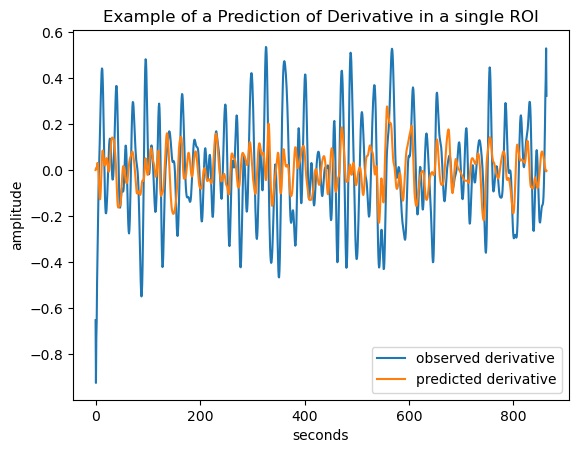

In [105]:
N=50
from sklearn.metrics import r2_score


for i in range(15,16):
    for j in range(1):
        indx = i*18 + j
            # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict(all_multiple[indx],) 

        # Compute derivatives with a finite difference method, for comparison
        x_dot_test_computed = model.differentiate( all_multiple[indx], t=t_multiple[indx])
        

        dist = np.zeros((n_vox,))
        for k in range(n_vox):
            sig_a = x_dot_test_computed[:,k]
            sig_b = x_dot_test_predicted[:,k]
            dist[k] = r2_score(sig_a, sig_b)


matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline 

t = 0.72*np.arange(1200)
plt.plot(t, x_dot_test_computed[:,34], label = 'observed derivative')
plt.plot(t, x_dot_test_predicted[:,34], label = 'predicted derivative')
plt.title('Example of a Prediction of Derivative in a single ROI')
plt.xlabel('seconds')
plt.ylabel('amplitude')


plt.legend()

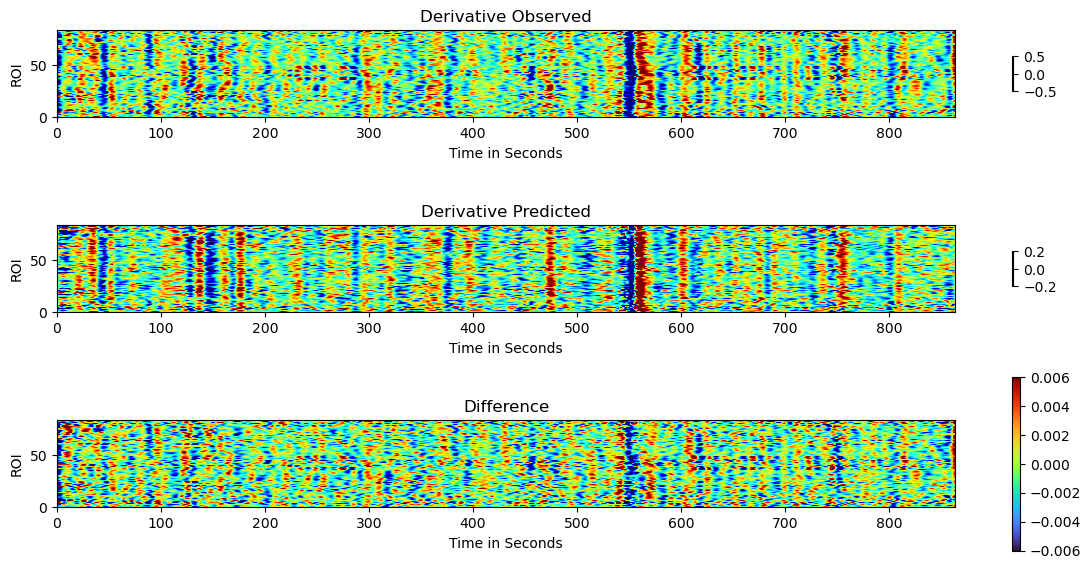

In [106]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=[12, 6])

# First subplot
ax1 = axes[0]
ax1.set_title("Derivative Observed")
im1 = ax1.imshow(np.transpose(x_dot_test_computed), cmap='jet', clim=(-0.5, 0.5), extent=[0, 1200*0.72, 0, 84])
fig.colorbar(im1, ax=ax1, shrink=0.2)
ax1.set_xlabel('Time in Seconds')
ax1.set_ylabel('ROI')

# Second subplot
ax2 = axes[1]
ax2.set_title("Derivative Predicted")
im2 = ax2.imshow(np.transpose(x_dot_test_predicted), cmap='jet', clim=(-0.2, 0.2), extent=[0, 1200*0.72, 0, 84])
fig.colorbar(im2, ax=ax2, shrink=0.2)
ax2.set_xlabel('Time in Seconds')
ax2.set_ylabel('ROI')
fig.tight_layout()

ax3 = axes[2]
ax3.set_title("Difference")
im2 = ax3.imshow(np.transpose(x_dot_test_computed) - 1.5*np.transpose(x_dot_test_predicted), cmap='jet', clim=(-0.5, 0.5), extent=[0, 1200*0.72, 0, 84])
fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('Time in Seconds')
ax3.set_ylabel('ROI')
fig.tight_layout()

plt.savefig('dynamics_ex.png')

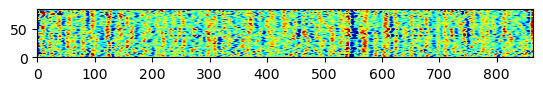

In [107]:
plt.imshow(np.transpose(x_dot_test_computed) - 1.5*np.transpose(x_dot_test_predicted), cmap='jet', clim=(-0.5, 0.5), extent=[0, 1200*0.72, 0, 84])

In [118]:
###### Check how much of the Derivative is captured by the model



N=50
all_corrs = np.zeros((N,18,n_vox))
all_corrs_int = np.zeros((N,18,n_vox))


tr = 0.72


for i in range(N):
    for j in range(18):
        indx = i*18 + j
            # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict( all_multiple[indx],) 

        # Compute derivatives with a finite difference method, for comparison
        x_dot_test_computed = model.differentiate( all_multiple[indx], t=t_multiple[indx])
        [n_len, nn] = np.shape(x_dot_test_computed)
        ts = np.linspace(0.0, tr*(n_len-5), n_len-4)
        
        sig1 = all_multiple[indx]
        sig2 = odeint(ode_int_der, init_cond, ts, args=(x_dot_test_computed,))
        sig3 = odeint(ode_int_der, init_cond, ts, args=(x_dot_test_predicted,))
        
        
        dist = np.zeros((n_vox,))
        dist_int = np.zeros((n_vox,))
        for k in range(n_vox):
            dist[k] =np.corrcoef(x_dot_test_computed[:,k], x_dot_test_predicted[:,k])[0,1]
            dist_int[k] = np.corrcoef(sig2[:,k], sig3[:,k])[0,1]

        all_corrs[i,j,:] = dist
        all_corrs_int[i,j,:] = dist_int




In [119]:
all_corrs_test = np.zeros((N,18,n_vox))
all_corrs_test_int = np.zeros((N,18,n_vox))

for i in range(N):
    for j in range(18):
        indx = i*18 + j
            # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict( test_multiple[indx],) 

        # Compute derivatives with a finite difference method, for comparison
        x_dot_test_computed = model.differentiate(test_multiple[indx], t=t_test_multiple[indx])
        
        
        [n_len, nn] = np.shape(x_dot_test_computed)
        ts = np.linspace(0.0, tr*(n_len-5), n_len-4)
        
        sig1 = test_multiple[indx]
        sig2 = odeint(ode_int_der, init_cond, ts, args=(x_dot_test_computed,))
        sig3 = odeint(ode_int_der, init_cond, ts, args=(x_dot_test_predicted,))
        
        
        dist = np.zeros((n_vox,))
        dist_int = np.zeros((n_vox,))
        for k in range(n_vox):
            dist[k] =np.corrcoef(x_dot_test_computed[:,k], x_dot_test_predicted[:,k])[0,1]
            dist_int[k] = np.corrcoef(sig2[:,k], sig3[:,k])[0,1]

        all_corrs_test[i,j,:] = dist
        all_corrs_test_int[i,j,:] = dist_int       

In [120]:
# Cell 1
indvar_train = np.mean(np.reshape(all_corrs[:,:4,:], [N, 4*n_vox]), 1)
indvar_test = np.mean(np.reshape(all_corrs_test[:,:4,:], [N, 4*n_vox]), 1)

x13 = np.hstack([np.array("Ind $\delta$") for i in range(N*2)])
x13_a = np.hstack([np.array("Training") for i in range(N)])
x13_b = np.hstack([np.array("Test") for i in range(N)])

all_re_train = np.reshape(all_corrs[:,:4,:], [50*4, n_vox])
a_1 = np.mean(all_re_train, 0)


toPlot = a_1[8:76]


all_re_test = np.reshape(all_corrs_test[:,:4,:], [50*4, n_vox])
a_2 = np.mean(all_re_test, 0)

all_t_train = np.reshape(all_corrs[:,4:,:], [50*14, n_vox])
a_3 = np.mean(all_t_train, 0)

all_t_test = np.reshape(all_corrs_test[:,4:,:], [50*14, n_vox])
a_4 = np.mean(all_t_test, 0)

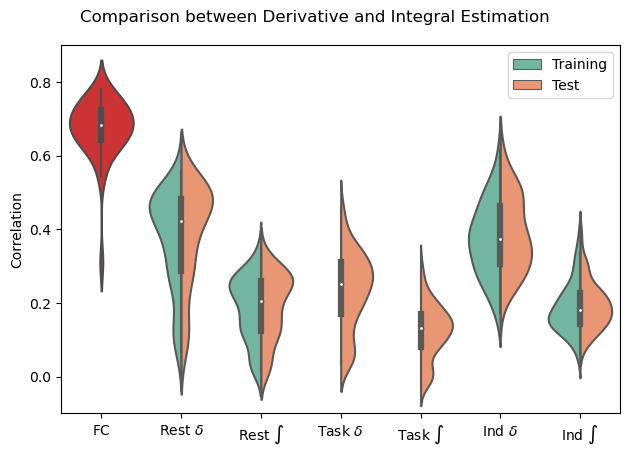

In [121]:
mmm = len(a_4)

x1_2 = np.hstack([np.array("Task $\delta$") for i in range(mmm*2)])
x1_1 = np.hstack([np.array("Rest $\delta$") for i in range(mmm*2)])
x1 = np.hstack([x1_1, x1_2, x13])

x2_2 = np.hstack([np.array("Training") for i in range(mmm)])
x2_1 = np.hstack([np.array("Test") for i in range(mmm)])
x2 = np.hstack([x2_2, x2_1, x2_1, x2_1, x13_a, x13_b])
x3 = np.hstack([a_1, a_2, a_3, a_4, indvar_train, indvar_test])

df1 = pd.DataFrame({
    "Rest vs Task": x1,
    "Train vs Test": x2,
    "Data": x3,
})

# Cell 2
indvar_train = np.mean(np.reshape(all_corrs_int[:,:4,:], [N, 4*n_vox]), 1)
indvar_test = np.mean(np.reshape(all_corrs_test_int[:,:4,:], [N, 4*n_vox]), 1)

x13 = np.hstack([np.array("Ind $\int$") for i in range(N*2)])
x13_a = np.hstack([np.array("Training") for i in range(N)])
x13_b = np.hstack([np.array("Test") for i in range(N)])

all_re_train = np.reshape(all_corrs_int[:,:4,:], [50*4, n_vox])
a_1 = np.mean(all_re_train, 0)

all_re_test = np.reshape(all_corrs_test_int[:,:4,:], [50*4, n_vox])
a_2 = np.mean(all_re_test, 0)

all_t_train = np.reshape(all_corrs_int[:,4:,:], [50*14, n_vox])
a_3 = np.mean(all_t_train, 0)

all_t_test = np.reshape(all_corrs_test_int[:,4:,:], [50*14, n_vox])
a_4 = np.mean(all_t_test, 0)

mmm = len(a_4)

mm = len(corr_vals_int)
x1_2 = np.hstack([np.array("Task $\int$") for i in range(mmm*2)])
x1_1 = np.hstack([np.array("Rest $\int$") for i in range(mmm*2)])
x1_4 = np.hstack([np.array("$\int$ + noise (FC)") for i in range(mm)])

x1 = np.hstack([x1_1, x1_2, x13, x1_4])

x2_2 = np.hstack([np.array("Training") for i in range(mmm)])
x2_1 = np.hstack([np.array("Test") for i in range(mmm)])
x1_4a = np.hstack([np.array("Training") for i in range(mm)])
x1_4b = np.hstack([np.array("Test") for i in range(mm)])

x2 = np.hstack([x2_2, x2_1, x2_1, x2_1, x13_a, x13_b,  x1_4a])
x3 = np.hstack([a_1, a_2, a_3, a_4, indvar_train, indvar_test, corr_vals_int])

df2 = pd.DataFrame({
    "Rest vs Task": x1,
    "Train vs Test": x2,
    "Data": x3,
})


df3 = pd.DataFrame({
    "Rest vs Task": x1_4,
    "Data": corr_vals_int
    
})
# Combine dataframes
df_combined = pd.concat([df1, df2])

color_palette = sns.color_palette("Set2", 6)
colors2 = sns.color_palette("Set1", 6)

fig, ax = plt.subplots()

sns.violinplot(x='Rest vs Task', y='Data', data=df3, palette=colors2, ax=ax)


# Create violin plot
sns.violinplot(x='Rest vs Task', y='Data', hue='Train vs Test', split=True,
               col='Derivative vs Integral', data=df_combined, palette=color_palette, order=['FC', 'Rest $\delta$', 'Rest $\int$', 'Task $\delta$', 'Task $\int$','Ind $\delta$', 'Ind $\int$'], ax=ax)

plt.legend(loc='upper right')
# Set plot title and labels
plt.suptitle("Comparison between Derivative and Integral Estimation", fontsize='large')


ax.set_ylabel("Correlation")
ax.set_ylim([-0.1, 0.8])

plt.xlabel(' ')
plt.ylabel("Correlation")
plt.ylim([-0.1, 0.9])
plt.tight_layout()

plt.savefig('dynamics.png')
plt.show()

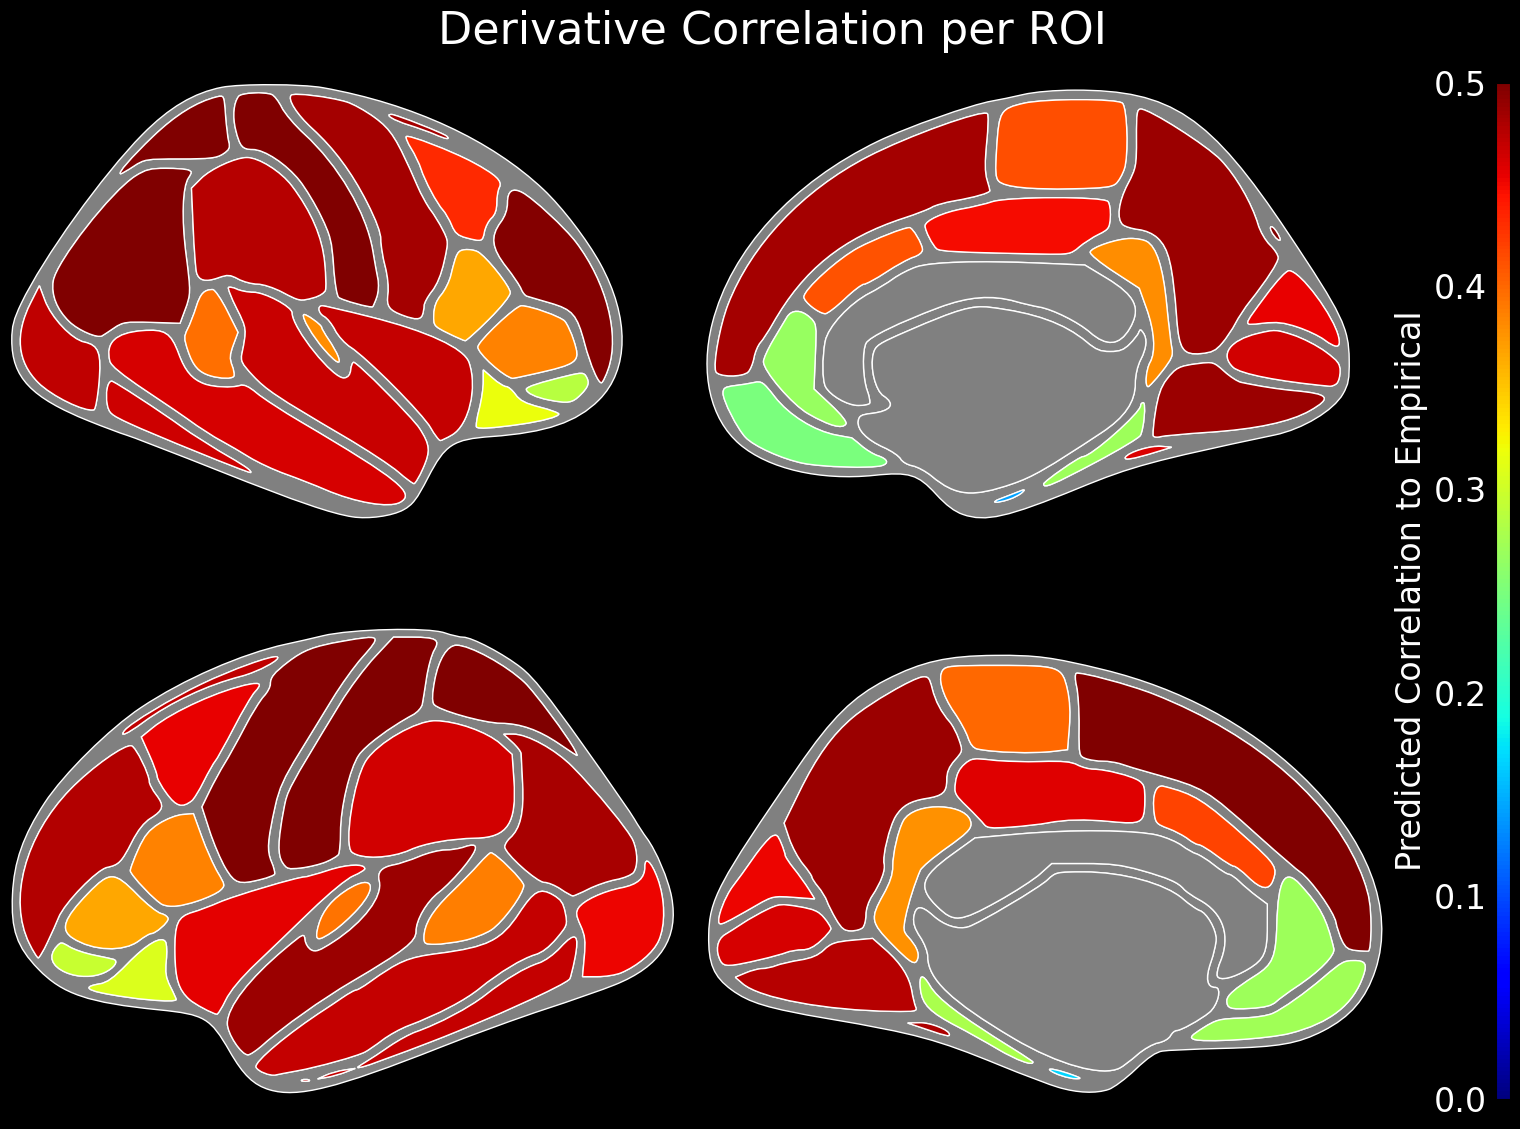

In [120]:
#### CHANGE COLOR SCHEME TO SINGLE COLOR



data = {(roi_cortical[i]) : float(toPlot[i]) 
        for i in range(68)}


ggseg.plot_dk(data, background='k', edgecolor='w', cmap='jet', vminmax = [0,0.5],
              bordercolor='gray', ylabel='Predicted Correlation to Empirical', title='Derivative Correlation per ROI', fontsize =32)


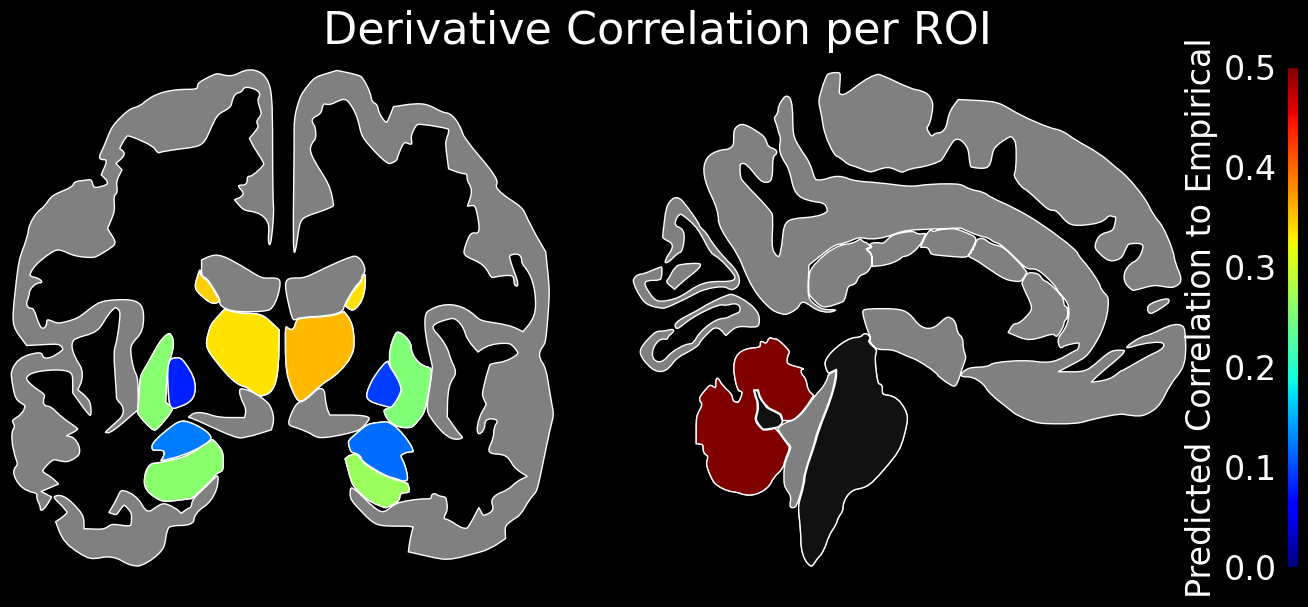

In [121]:

import ggseg

toPlot = np.concatenate([a_1[:8], a_1[76:], [0.5*(a_1[0]+ a_1[83])]])


all_subcortical = np.concatenate([ subcortical_r[::-1], subcortical_l, ['Cerebellum-Cortex']])

data = {(all_subcortical[i]) : float(toPlot[i]) 
        for i in range(17)}


ggseg.plot_aseg(data, background='k', edgecolor='w', cmap='jet', vminmax = [0,0.5],
              bordercolor='gray', ylabel='Predicted Correlation to Empirical', title='Derivative Correlation per ROI', fontsize =32)



In [114]:
data = {(roi_all[i]) : float(a_1[i]) 
        for i in range(n_vox)}
print(data)

{'Right-Cerebellum': 0.3481615945852053, 'Right-Thalamus': 0.14725759960520393, 'Right-Caudate': 0.13939661939078302, 'Right-Putamen': 0.09262886689271335, 'Right-Pallidum': 0.021884594927047377, 'Right-Hippocampus': 0.12607304788184556, 'Right-Amygdala': 0.030928379782644524, 'Right-Accumbens': 0.01823407387069075, 'insula_right': 0.25090580848045296, 'entorhinal_right': 0.04732286929093913, 'parahippocampal_right': 0.11061094344896842, 'temporalpole_right': 0.0441622747361012, 'frontalpole_right': 0.027534809320685364, 'fusiform_right': 0.2578288649160465, 'transversetemporal_right': 0.17006628471838717, 'lateraloccipital_right': 0.2513454257803333, 'superiorparietal_right': 0.32078979580603806, 'inferiortemporal_right': 0.2506943279068641, 'inferiorparietal_right': 0.28326216480755895, 'supramarginal_right': 0.23229921703845502, 'bankssts_right': 0.20617630891903357, 'middletemporal_right': 0.2334242307049683, 'superiortemporal_right': 0.2558082169861843, 'postcentral_right': 0.2861

In [115]:

tr = 0.72
ts = np.linspace(0.0, tr*1095, 1096)


check = [20,40,60, 80, 100, 200, 500,1000]

N=50
tr = 0.72

full_dist = []
full_dist_der = []

for i in range(N):
    for j in range(4):
        indx = i*18 + j
            # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict( test_multiple[indx],) 
        x_dot_test_computed = model.differentiate( test_multiple[indx], t=t_multiple[indx])

        #Integrate the signal
        init_cond = test_multiple[indx][99,:]
        
        #print(np.shape(ts))
        #print(np.shape(x_dot_test_predicted[99:,:]))
        sig1 = test_multiple[indx][99:,:]
        sig2 = odeint(ode_int_der, init_cond, ts, args=(x_dot_test_computed[99:,:],))
        sig3 = odeint(ode_int_der, init_cond, ts, args=(x_dot_test_predicted[99:,:],))
        
        
        # Compute derivatives with a finite difference method, for comparison
        dist = np.zeros((n_vox,8))
        dist_der = np.zeros((n_vox,8))
        for c in range(8):   
            for k in range(n_vox):
                sig_a = sig2[:check[c],k]
                sig_b = sig3[:check[c],k]
                sig_c = x_dot_test_computed[99:99+check[c], k]
                sig_d = x_dot_test_predicted[99:99+check[c], k]
                
                dist[k,c] =np.corrcoef(sig_a, sig_b)[0,1]
                dist_der[k,c] =np.corrcoef(sig_c, sig_d)[0,1]

        full_dist.append(dist)
        full_dist_der.append(dist_der)


C:\Users\amrit\AppData\Local\Temp\ipykernel_10140\3894112663.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_ = [np.rint(np.float(l)*0.72) for l in label]
C:\Users\amrit\AppData\Local\Temp\ipykernel_10140\3894112663.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label_)


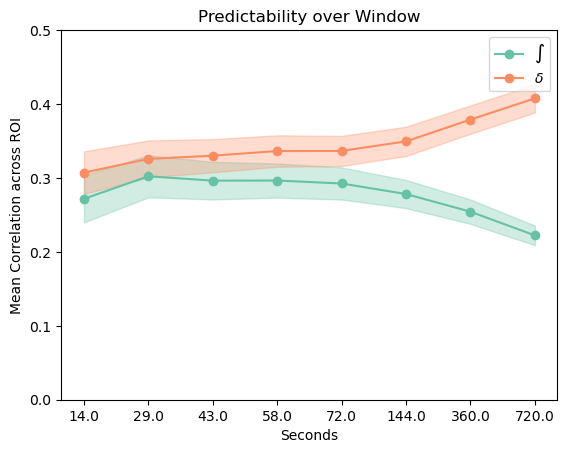

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
fd= np.mean(full_dist, axis = 1)
fd_int = np.mean(full_dist_der, axis =1)

# Calculate mean and standard deviation for fd
mean_fd = np.mean(fd, axis=0)
std_fd = np.std(fd, axis=0)
n_fd = len(fd)
ci_fd = 1.96 * std_fd / np.sqrt(n_fd)  # 95% confidence interval

# Calculate mean and standard deviation for fd_int
mean_fd_int = np.mean(fd_int, axis=0)
std_fd_int = np.std(fd_int, axis=0)
n_fd_int = len(fd_int)
ci_fd_int = 1.96 * std_fd_int / np.sqrt(n_fd_int)  # 95% confidence interval

# X-axis values (timepoints)
timepoints = np.arange(len(mean_fd))

# Create figure and axes
fig, ax = plt.subplots()

# Set color palette
colors = sns.color_palette('Set2')

label = [0,20,40,60, 80, 100, 200, 500,1000]
label_ = [np.rint(np.float(l)*0.72) for l in label]


# Plot fd line and confidence interval
ax.plot(timepoints, mean_fd, '-o', color=colors[0], label='$\int$')
ax.fill_between(timepoints, mean_fd - ci_fd, mean_fd + ci_fd, alpha=0.3, color=colors[0]) #, label='fd CI')

# Plot fd_int line and confidence interval
ax.plot(timepoints, mean_fd_int, '-o', color=colors[1], label='$\delta$')
ax.fill_between(timepoints, mean_fd_int - ci_fd_int, mean_fd_int + ci_fd_int, alpha=0.3, color=colors[1]) #, label='fd_int CI')
ax.set_xticklabels(label_)
# Set x-axis and y-axis labels
ax.set_xlabel('Seconds')
ax.set_ylabel('Mean Correlation across ROI')
ax.set_ylim([0,0.5])

# Set plot title
ax.set_title('Predictability over Window')

# Add legend
ax.legend()

plt.savefig('pred_window.png')
# Show the plot
plt.show()


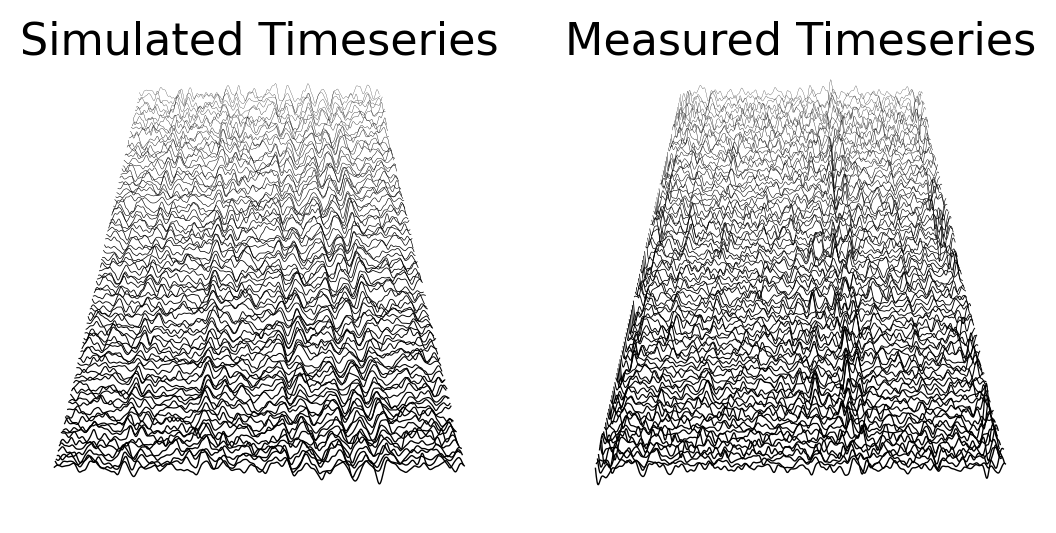

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


plt.rcParams['figure.dpi'] = 200
fig, axs = plt.subplots(1,2, frameon=False)


# Generate random data
data = full_sig
X = np.linspace(-1, 1, data.shape[-1])
G = 1#1.5 * np.exp(-4 * X ** 2)

# Generate line plots
lines = []
for i in range(len(data)):
    # Small reduction of the X extents to get a cheap perspective effect
    xscale = 1 - i / 200.
    # Same for linewidth (thicker strokes on bottom)
    lw = .5 - i / 200.0
    line, = axs[0].plot(xscale * X, i + G * data[i], color="k", lw=lw)
    lines.append(line)

# Set y limit (or first line is cropped because of thickness)
axs[0].set_ylim(-10, 90)

# No ticks
axs[0].set_xticks([])
axs[0].set_yticks([])

# 2 part titles to get different font weights
axs[0].text(0.5, 1.0, "Simulated Timeseries", transform=axs[0].transAxes,
        ha="center", va="bottom", color="k",
        family="sans-serif", fontweight="light", fontsize=16)

# Generate random data
data = rest[13,:,:1000]
X = np.linspace(-1, 1, data.shape[-1])
G = 1#1.5 * np.exp(-4 * X ** 2)

# Generate line plots
lines = []
for i in range(len(data)):
    # Small reduction of the X extents to get a cheap perspective effect
    xscale = 1 - i / 200.
    # Same for linewidth (thicker strokes on bottom)
    lw = .5 - i / 200.0
    line, = axs[1].plot(xscale * X, i + G * data[i], color="k", lw=lw)
    lines.append(line)

# Set y limit (or first line is cropped because of thickness)
axs[1].set_ylim(-10, 90)

# No ticks
axs[1].set_xticks([])
axs[1].set_yticks([])

# 2 part titles to get different font weights
axs[1].text(0.5, 1.0, "Measured Timeseries", transform=axs[1].transAxes,
        ha="center", va="bottom", color="k",
        family="sans-serif", fontweight="light", fontsize=16)

axs[1].axis('off')
axs[0].axis('off')
axs[1].set_box_aspect(1)

axs[0].set_box_aspect(1)

In [15]:
#### Pareto tradeoff varying diagonal, sparsity and evaluating on rsquared to dynamics and correlation to SC

from scipy import integrate
from joblib import Parallel, delayed


library = ps.PolynomialLibrary(include_bias = False,include_interaction=False, degree=7)
library.fit(np.transpose(rest[1]))
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())


#contraints

lhs = np.zeros((n_vox, n_vox * n_features))

for i in range(n_vox):
    lhs[i, i+i*n_features]=1


specialk = np.linspace(10, 70, num=10)
specialn = np.linspace(0.03, 0.2, num=10)

xx = 10
yy = 10

n_sp = 41

diagonal_ = np.zeros((xx, yy))
threshold_ = np.zeros((xx, yy))
score_ = np.zeros((xx, yy))
corr_= np.zeros((xx, yy))
trajectories_ = np.zeros((xx, yy, 501))


def lets_int(odefn_, init_one_, t_axis_, ip_):
    return odeint(odefn_, init_one_, t_axis_, args=(ip_,))

init = 0
margin = 0.001

init_pts = []
count =0
for i in range(447*4):
    for j in range(1200):
        if np.abs(rest_only[i][j,1] - init) < margin:
            init_pts.append(rest_only[i][j,:])
            count = count + 1

    if count > 100:
        break


for i in range(xx):
    print(i)
    for j in range(yy):

        rhs = np.array([-0.125*specialk[i]*specialn[j] for ll in range(n_vox)])
        diffrentiator =  ps.SINDyDerivative(kind='spectral',  drop_endpoints=True)
        optimizer = ps.ConstrainedSR3(constraint_rhs=rhs, constraint_lhs=lhs,  threshold=8/(specialk[i]), nu=10, thresholder= "l2")
        model = ps.SINDy(optimizer=optimizer, feature_library=library, differentiation_method= diffrentiator)


        model.fit( rest_only, t=t_multiple_only, multiple_trajectories = True)

        a=model.coefficients()
        bb= np.mean(np.diag(a[:,:n_vox]))
        diagonal_[i,j] = bb
        threshold_[i,j] = 8/(specialk[i])

        c = np.mean([model.score(rest_only[x], t= t_multiple_only[x]) for x in range(20)])
        score_[i,j] = c
#        dist = np.zeros((n_vox,20))
#        for indx in range(20):
#            x_dot_test_predicted = model.predict( rest_only[indx],) 
#            x_dot_test_computed = model.differentiate( rest_only[indx], t=t_multiple_only[indx])

            
#            for k in range(n_vox):
#                sig_a = x_dot_test_computed[:,k]
#                sig_b = x_dot_test_predicted[:,k]
#                dist[k,indx] =np.corrcoef(sig_a, sig_b)[0,1]

#        score_[i,j] = np.median(np.mean(dist, axis =1))
        
        
        w1 = np.array(a[:,:n_vox])
        corr1 = np.zeros((n_dti,))

        for k in range(n_dti):
            mat = norm_connectomes[k]
            corr1[k] = hemi_corrcoef(w1, mat)
        
        corr_[i,j] = np.mean(corr1)
        
        ode_fn = ode_solve_sindy_10(a, 7)
        
        ip = np.zeros((20000,n_vox))
        t_axis = np.arange(0, 500 * dt/10, dt/10)

        ip[0:35,1]  = np.array([0.008*x for x in range(35)])
        ip[35:70,1] = [0.008*(35-x) for x in range(35)]

        trajectories = []
        for init_one in init_pts:
            s = odeint(ode_fn, init_one, t_axis, args=(ip,))
            trajectories.append(s)

        trajectories_[i,j] = np.median(trajectories, axis = 0)[:,1]
        


Features (588): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x0^2', 'x1^2', 'x2^2', 'x3^2', 'x4^2', 'x5^2', 'x6^2', 'x7^2', 'x8^2', 'x9^2', 'x10^2', 'x11^2', 'x12^2', 'x13^2', 'x14^2', 'x15^2', 'x16^2', 'x17^2', 'x18^2', 'x19^2', 'x20^2', 'x21^2', 'x22^2', 'x23^2', 'x24^2', 'x25^2', 'x26^2', 'x27^2', 'x28^2', 'x29^2', 'x30^2', 'x31^2', 'x32^2', 'x33^2', 'x34^2', 'x35^2', 'x36^2', 'x37^2', 'x38^2', 'x39^2', 'x40^2', 'x41^2', 'x42^2', 'x43^2', 'x44^2', 'x45^2', '

C:\Users\amrit\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\amrit\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\amrit\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\amrit\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1


C:\Users\amrit\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\amrit\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\amrit\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


2


C:\Users\amrit\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


3
4
5
6
7
8
9


In [16]:
np.savetxt('score_.txt', score_)
np.savetxt('corr_.txt', corr_)
np.savetxt('trajectories_.txt', np.reshape(trajectories_, [xx*yy, 501]))

In [26]:
score_ = np.loadtxt('score_.txt')
corr_ = np.loadtxt('corr_.txt')
dd = np.stack([diagonal_ for i in range(10)])

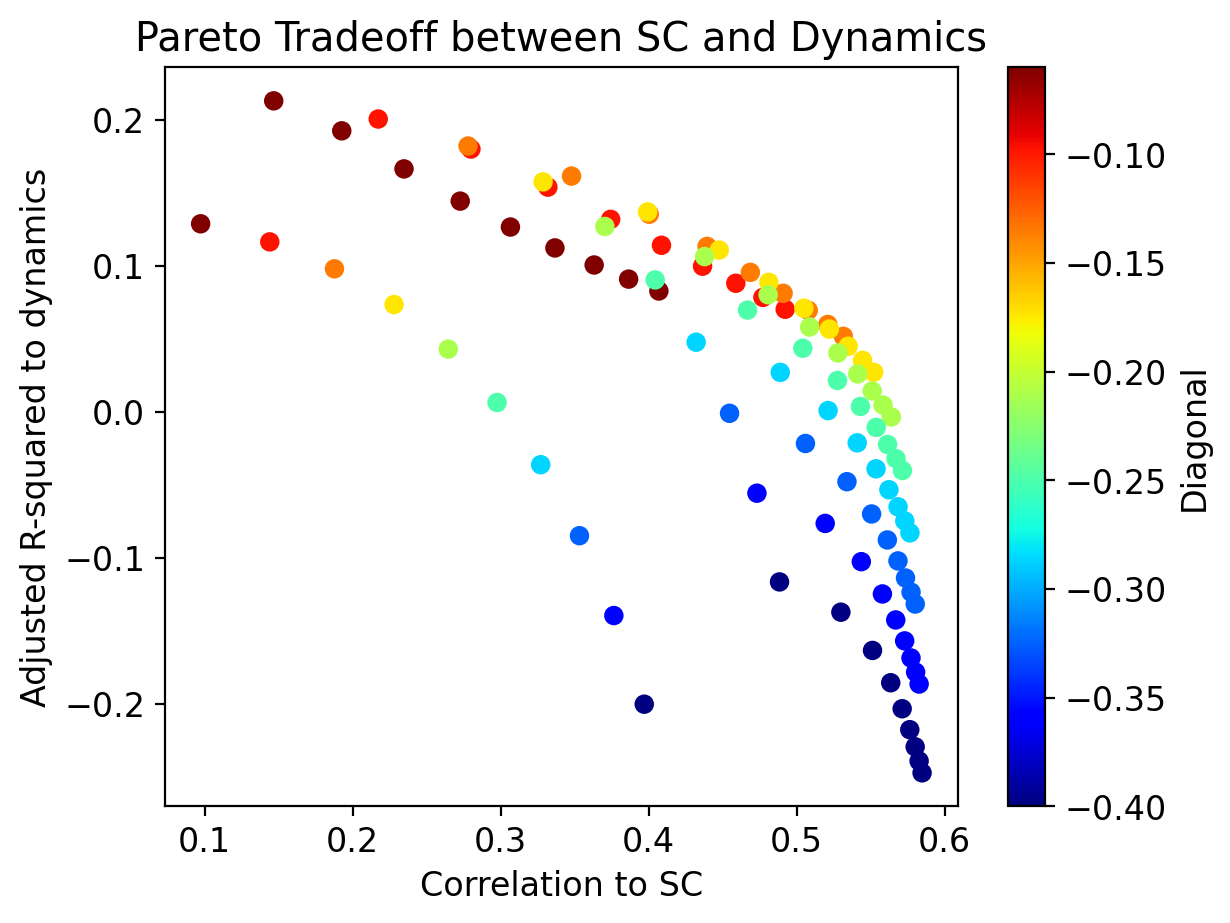

In [39]:

plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 12})
cc = scatter3d(corr_.flatten()[::-1], score_.flatten()[::-1], dd.flatten()[::-1])


In [25]:
#### Pareto tradeoff varying diagonal, sparsity and evaluating on rsquared to dynamics and correlation to SC

from scipy import integrate
from joblib import Parallel, delayed


library = ps.PolynomialLibrary(include_bias = False,include_interaction=False, degree=7)
library.fit(np.transpose(rest[1]))
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())


#contraints

lhs = np.zeros((n_vox, n_vox * n_features))

for i in range(n_vox):
    lhs[i, i+i*n_features]=1


specialk = np.linspace(10, 70, num=10)
specialn = np.linspace(0.03, 0.2, num=10)

init = 0
margin = 0.001

init_pts = []

count =0
for i in range(447*4):
    for j in range(1200):
        if np.abs(rest_only[i][j,1] - init) < margin:
            init_pts.append(rest_only[i][j,:])
            count = count + 1

    if count > 100:
        break


#trajectories_ = np.zeros((10,501))
diagonal_ = np.zeros((10,))

for j in range(10):
    rhs = np.array([-0.125*specialk[1]*specialn[j] for ll in range(n_vox)])
    diffrentiator =  ps.SINDyDerivative(kind='spectral',  drop_endpoints=True)
    optimizer = ps.ConstrainedSR3(constraint_rhs=rhs, constraint_lhs=lhs,  threshold=8/(specialk[1]), nu=10, thresholder= "l2")
    model = ps.SINDy(optimizer=optimizer, feature_library=library, differentiation_method= diffrentiator)

    model.fit( rest_only[:5], t=t_multiple_only[:5], multiple_trajectories = True)
    
    a=model.coefficients()
    bb= np.mean(np.diag(a[:,:n_vox]))
    diagonal_[j] = bb
    #ode_fn = ode_solve_sindy_10(a, 7)
        
    #ip = np.zeros((20000,n_vox))
    #t_axis = np.arange(0, 500 * dt/10, dt/10)

    #ip[0:35,1]  = np.array([0.008*x for x in range(35)])
    #ip[35:70,1] = [0.008*(35-x) for x in range(35)]

    #trajectories = []
    #for init_one in init_pts:
    #    s = odeint(ode_fn, init_one, t_axis, args=(ip,))
    #    trajectories.append(s)

    #trajectories_[j,:] = np.median(trajectories, axis = 0)[:,1]


Features (588): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x0^2', 'x1^2', 'x2^2', 'x3^2', 'x4^2', 'x5^2', 'x6^2', 'x7^2', 'x8^2', 'x9^2', 'x10^2', 'x11^2', 'x12^2', 'x13^2', 'x14^2', 'x15^2', 'x16^2', 'x17^2', 'x18^2', 'x19^2', 'x20^2', 'x21^2', 'x22^2', 'x23^2', 'x24^2', 'x25^2', 'x26^2', 'x27^2', 'x28^2', 'x29^2', 'x30^2', 'x31^2', 'x32^2', 'x33^2', 'x34^2', 'x35^2', 'x36^2', 'x37^2', 'x38^2', 'x39^2', 'x40^2', 'x41^2', 'x42^2', 'x43^2', 'x44^2', 'x45^2', '

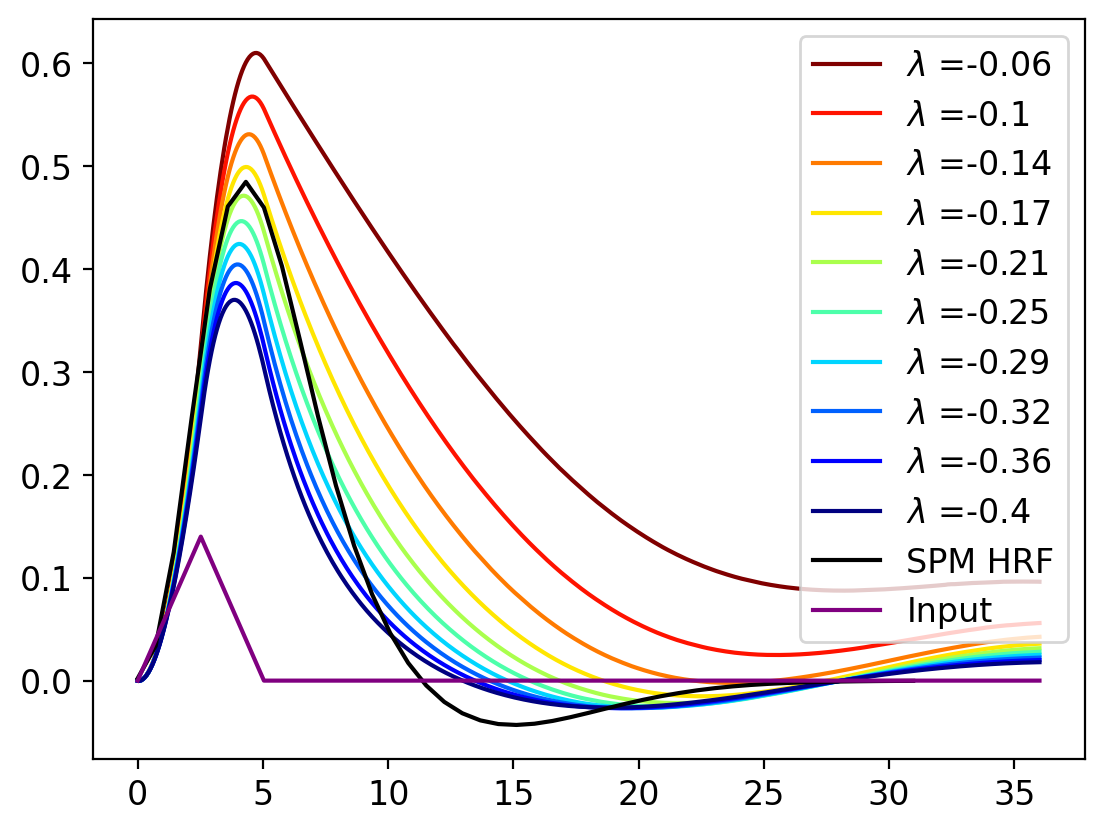

In [59]:
import matplotlib.cm as cmx

hrf=np.loadtxt('hrf.txt')
hrf_t = 0.72*np.linspace(1, 45, 45) -0.72  

cm = plt.get_cmap('jet')
cNorm =  matplotlib.colors.Normalize(vmin=min(diagonal_), vmax=max(diagonal_))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    

for i in range(10):
    plt.plot(t_axis , np.transpose(trajectories_[i,:]), color = scalarMap.to_rgba(diagonal_[i]), label = '$\lambda$ ='+str(np.round(diagonal_[i],2)))


plt.plot(hrf_t[:44], 3.2*hrf[1:], color = 'k', label = 'SPM HRF')
plt.plot(t_axis, 0.5*ip[:501,1], color = 'purple', label = 'Input')
plt.legend()

plt.savefig('huzzah.png')

In [20]:
#### Test across Polynomial Orders



specialk = 23.333333333333336
specialn = 0.10555555555555556
tr = 0.72
n_time = 1000

diagonal_ = np.zeros((7, 1))
threshold_ = np.zeros((7, 1))
score_ = np.zeros((7, n_vox))
corr_= np.zeros((7, n_dti))

corr_vals_int = np.zeros((7,20))

for xx in range(7):
        
    library = ps.PolynomialLibrary(include_bias = False,include_interaction=False, degree=xx+1)
    library.fit(np.transpose(rest[1]))
    n_features = library.n_output_features_
    print(f"Features ({n_features}):", library.get_feature_names())


    lhs = np.zeros((n_vox, n_vox * n_features))

    for i in range(n_vox):
        lhs[i, i+i*n_features]=1

    rhs = np.array([-0.125*specialk*specialn for ll in range(n_vox)])
    diffrentiator =  ps.SINDyDerivative(kind='spectral',  drop_endpoints=True)
    optimizer = ps.ConstrainedSR3(constraint_rhs=rhs, constraint_lhs=lhs,  threshold=8/(specialk), nu=10, thresholder= "l2")
    model = ps.SINDy(optimizer=optimizer, feature_library=library, differentiation_method= diffrentiator)


    model.fit( rest_only, t=t_multiple_only, multiple_trajectories = True)

   # score_[xx,:] = [model.score(rest_only[x], t= t_multiple_only[x]) for x in range(20)]
    dist = np.zeros((20, n_vox))
    for indx in range(20):
        x_dot_test_predicted = model.predict(  rest_only[indx],) 
        x_dot_test_computed = model.differentiate(  rest_only[indx], t=t_multiple_only[indx])
        
        for k in range(n_vox):
            sig_a = x_dot_test_computed[:,k]
            sig_b = x_dot_test_predicted[:,k]
            dist[indx, k] =np.corrcoef(sig_a, sig_b)[0,1]

    
    score_[xx,:] = np.mean(dist, axis = 0)

    
    a=model.coefficients()
    w1 = np.array(a[:,:n_vox])

    for k in range(n_dti):
        mat = norm_connectomes[k]
        corr_[xx,k] = hemi_corrcoef(w1, mat)
    
    
    
    
    ts = np.linspace(0.0, tr*n_time, n_time+1)
    ode_fn = ode_solve_sindy(a, xx+1)

    cor = np.zeros((20, n_vox, n_vox))

    for j in range(20):
        init_cond = np.random.normal(0, 0.1, n_vox)
        noise = np.random.normal(0, 0.13, (n_time*5)*n_vox)
        noise = np.reshape(noise, [n_time*5,n_vox])

        s = np.array(odeint(ode_fn, init_cond, ts, args=(np.array(noise),)))
        full_sig = np.array([stats.zscore(myfilter(s[:,i], 0.72)) for i in range(n_vox)])

        cor[j] = np.corrcoef(full_sig)


        corr_vals_int[xx,j] = np.corrcoef(avg_fc.flatten(), cor[j].flatten())[0,1]
    
    



Features (84): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83']
Features (168): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 

Features (504): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x0^2', 'x1^2', 'x2^2', 'x3^2', 'x4^2', 'x5^2', 'x6^2', 'x7^2', 'x8^2', 'x9^2', 'x10^2', 'x11^2', 'x12^2', 'x13^2', 'x14^2', 'x15^2', 'x16^2', 'x17^2', 'x18^2', 'x19^2', 'x20^2', 'x21^2', 'x22^2', 'x23^2', 'x24^2', 'x25^2', 'x26^2', 'x27^2', 'x28^2', 'x29^2', 'x30^2', 'x31^2', 'x32^2', 'x33^2', 'x34^2', 'x35^2', 'x36^2', 'x37^2', 'x38^2', 'x39^2', 'x40^2', 'x41^2', 'x42^2', 'x43^2', 'x44^2', 'x45^2', '

C:\Users\amrit\AppData\Local\Temp\ipykernel_35864\502396951.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(ytick_labels, fontsize='20')


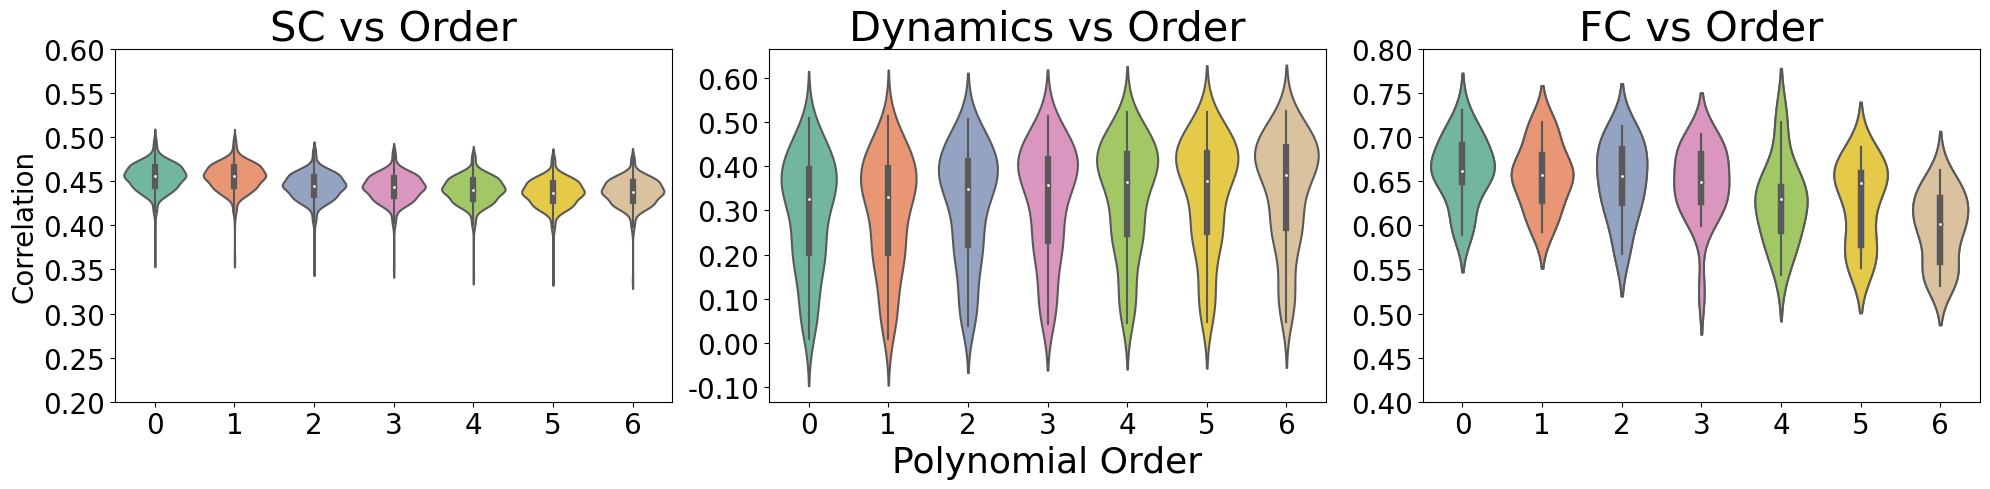

In [61]:
alldy =  score_.flatten()


fig, axes = plt.subplots(1,3, figsize=(20, 5))



mmm=84
x1 = np.hstack([np.array("1st") for i in range(mmm)])
x2 = np.hstack([np.array("2rd") for i in range(mmm)])
x3 = np.hstack([np.array("3th") for i in range(mmm)])
x4 = np.hstack([np.array("4th") for i in range(mmm)])
x5 = np.hstack([np.array("5th") for i in range(mmm)])
x6 = np.hstack([np.array("6th") for i in range(mmm)])
x7 = np.hstack([np.array("7th") for i in range(mmm)])

x_label = np.hstack([x1, x2, x3, x4, x5, x6, x7])


sns.set_palette("Set2")

df = pd.DataFrame({"x_l": x_label,
                    "Data": alldy
})


sns.violinplot(ax = axes[1] , x="x_l",y= "Data", data=df)


axes[1].set_title("Dynamics vs Order", 
           fontsize = 30)
axes[1].set_ylabel("")

axes[1].set_xlabel("Polynomial Order", fontsize = 26)

alldy = corr_.flatten()

mmm=n_dti
x1 = np.hstack([np.array("1st") for i in range(mmm)])
x2 = np.hstack([np.array("2rd") for i in range(mmm)])
x3 = np.hstack([np.array("3th") for i in range(mmm)])
x4 = np.hstack([np.array("4th") for i in range(mmm)])
x5 = np.hstack([np.array("5th") for i in range(mmm)])
x6 = np.hstack([np.array("6th") for i in range(mmm)])
x7 = np.hstack([np.array("7th") for i in range(mmm)])

x_label = np.hstack([x1, x2, x3, x4, x5, x6, x7])


df = pd.DataFrame({"x_l": x_label,
                    "Data": alldy
})


sns.violinplot(ax = axes[0], x="x_l",y= "Data", data=df)
axes[0].set_title("SC vs Order", 
           fontsize = 30)
axes[0].set_ylabel("Correlation", fontsize = 20)
axes[0].set_ylim([0.2, 0.6])
axes[0].set_xlabel("")



alldy =  corr_vals_int.flatten()


mmm=20
x1 = np.hstack([np.array("1st") for i in range(mmm)])
x2 = np.hstack([np.array("2rd") for i in range(mmm)])
x3 = np.hstack([np.array("3th") for i in range(mmm)])
x4 = np.hstack([np.array("4th") for i in range(mmm)])
x5 = np.hstack([np.array("5th") for i in range(mmm)])
x6 = np.hstack([np.array("6th") for i in range(mmm)])
x7 = np.hstack([np.array("7th") for i in range(mmm)])

x_label = np.hstack([x1, x2, x3, x4, x5, x6, x7])


df = pd.DataFrame({"x_l": x_label,
                    "Data": alldy
})


sns.violinplot(ax = axes[2] ,x="x_l",y= "Data", data=df)


sns.violinplot(ax = axes[2], x="x_l",y= "Data", data=df)
axes[2].set_title("FC vs Order", 
           fontsize = 30)
axes[2].set_ylabel("")
axes[2].set_ylim([0.4, 0.8])
axes[2].set_xlabel("")

for i in range(3):
    ytick_labels = [f'{tick:.2f}' for tick in axes[i].get_yticks()]
    axes[i].set_yticklabels(ytick_labels, fontsize='20')
    axes[i].set_xticklabels(axes[i].get_xticks(), fontsize='20')


fig.tight_layout()

plt.savefig('SCDYN.png')

In [24]:
###############Working Memmory Stufff
#############################################################################################################
n_vox = 84
fmri = np.genfromtxt('C:\\Users\\amrit\\Documents\\Volume\\wm_lr447cerb.txt')
n_subj = 447
wm_fmri_lr = np.reshape(fmri, [n_subj,405,n_vox])



fmri = np.genfromtxt('C:\\Users\\amrit\\Documents\\Volume\\wm_rl447cerb.txt')
n_subj = 447
wm_fmri_rl = np.reshape(fmri, [n_subj,405,n_vox])





wm_lr = np.zeros((n_subj,84,405))

for j in range(n_subj):
    for i in range(84):
        wm_lr[j,int(LUT[i]),:] = wm_fmri_lr[j,:,i]

wm_rl = np.zeros((n_subj,84,405))

for j in range(n_subj):
    for i in range(84):
        wm_rl[j,int(LUT[i]),:] = wm_fmri_rl[j,:,i]

wm=np.zeros((n_subj*2, n_vox, 405))

wm[:n_subj,:,:] = wm_lr
wm[n_subj:,:,:] = wm_rl

In [25]:
#### Load Behavioral Data

rt_lr = np.genfromtxt('C:\\Users\\amrit\\Documents\\Volume\\rt_447lr_wm_ext.txt')
n_subj = 447
rt_lr = np.reshape(rt_lr ,[n_subj, 4, 80])



rt_rl = np.genfromtxt('C:\\Users\\amrit\\Documents\\Volume\\rt_447rl_wm_ext.txt')
n_subj = 447
rt_rl = np.reshape(rt_rl ,[n_subj, 4, 80])


#colums are as follows
#0. RT  1. ACC (1 good trial) 2. Type 3. 0vs2 back (0 is 0 back)
#Type - 0 Tools, 1 Face, 2 Body, 3 Place

times_lr = np.genfromtxt('C:\\Users\\amrit\\Documents\\Volume\\wm_lr447cuesall.txt')
times_lr = np.reshape(times_lr ,[447, 3, 80])

times_rl = np.genfromtxt('C:\\Users\\amrit\\Documents\\Volume\\wm_rl447cuesall.txt')
times_rl = np.reshape(times_rl ,[447, 3, 80])


behall= np.zeros(([n_subj*2, 5, 80]))
behall[:n_subj,:4,:]= rt_lr
behall[:n_subj,4,:] = times_lr[:,0,:]

behall[n_subj:,:4,:]= rt_rl
behall[n_subj:,4,:] = times_rl[:,0,:]

In [26]:
wm_multiple = []
wmt_multiple = []
for i in range(n_subj*2):   
    wm_multiple.append(np.transpose(wm[i,:,:]))

    wmt_multiple.append(np.arange(0, 405 * dt, dt))


In [27]:
#### TRAINING A MODEL FOR WM ONLY
diffrentiator =  ps.SINDyDerivative(kind='spectral',  drop_endpoints=True)
optimizer = ps.ConstrainedSR3(constraint_rhs=rhs, constraint_lhs=lhs,  threshold=8/(specialk), nu=10, thresholder= "l2")
wmmodel = ps.SINDy(optimizer=optimizer, feature_library=library, differentiation_method= diffrentiator)
#wmmodel.inital_guess = a
wmmodel.fit( wm_multiple, t= wmt_multiple, multiple_trajectories = True)

b=wmmodel.coefficients()
diagonalwm = np.mean(np.diag(b[:,:84]))
scorewm = np.mean([wmmodel.score(wm_multiple[x], t= wmt_multiple[x]) for x in range(20)])


w1wm = np.array(b[:,:n_vox])
corr1 = np.zeros((n_dti,))

for k in range(n_dti):
    mat = norm_connectomes[k]
    corr1[k] = hemi_corrcoef(w1wm, mat)



[corr1_r, corr1h_r, corrc1_r] = sc_calc(all_connectomes,  w1, n_dti) 

0.09612353999842627
0.43527865741635674


In [104]:
N = 200
all_corrs_test_wm = np.zeros((N,n_vox))
all_corrs_test_rest = np.zeros((N,n_vox))

for i in range(N):
       #compute for WM model
        x_dot_test_predictedwm = wmmodel.predict(wm_multiple[i],) 
       #compute for Rest Model
        x_dot_test_predicted = model.predict(wm_multiple[i],) 
        x_dot_test_computed = model.differentiate(wm_multiple[i], t=wmt_multiple[i])
        
        dist_rest = np.zeros((n_vox,))
        dist_wm = np.zeros((n_vox,))
        for k in range(n_vox):
            dist_rest[k] =np.corrcoef(x_dot_test_computed[:,k], x_dot_test_predicted[:,k])[0,1]
            dist_wm[k] = np.corrcoef(x_dot_test_computed[:,k], x_dot_test_predictedwm[:,k])[0,1]
        
        all_corrs_test_rest[i] = dist_rest
        all_corrs_test_wm[i] = dist_wm
        
a1_rest = np.mean( all_corrs_test_rest, 0)
a1_wm = np.mean( all_corrs_test_wm, 0)

In [124]:
n_subj = 447*2
all_wm = np.stack([np.corrcoef(wm[xx,:,:1200*4]) for xx in range(n_subj)])

avg_wmfc = np.mean(all_wm, 0)

n_time = 1200

corr_vals_int_wm = np.squeeze(np.zeros((40,)))
corr_vals_int_rest = np.squeeze(np.zeros((40,)))
tr = 0.72


ts = np.linspace(0.0, tr*n_time, n_time+1)
ode_fn = ode_solve_sindy(np.array(wmmodel.coefficients()), 7)

cor = np.zeros((40, n_vox, n_vox))

for j in range(40):
    init_cond = np.random.normal(0, 0.1, n_vox)
    noise = np.random.normal(0, 0.13, (n_time*5)*n_vox)
    noise = np.reshape(noise, [n_time*5,n_vox])

    s = np.array(odeint(ode_fn, init_cond, ts, args=(np.array(noise),)))
    full_sig = np.array([stats.zscore(myfilter(s[:,i], 0.72)) for i in range(n_vox)])

    cor[j] = np.corrcoef(full_sig)


    corr_vals_int_rest[j] = np.corrcoef(avg_fc.flatten(), cor[j].flatten())[0,1]
    corr_vals_int_wm[j] = np.corrcoef(avg_wmfc.flatten(), cor[j].flatten())[0,1]


In [30]:
n_vox = 84
n_time = 405
x_dot_predicted = np.zeros((n_subj*2,n_vox,n_time))
x_dot_computed = np.zeros((n_subj*2,n_vox,n_time))



diff=  np.zeros((n_subj*2,n_vox,n_time))

c1 = 1
c2 = -1

for indx in range(447*2):
        ###modeling the Task Independent Signal
    x_dot_predicted[indx,:,:] = np.transpose(c1*model.predict(wm_multiple[indx],) + c2*wmmodel.predict(wm_multiple[indx],)) 
    
        ###Subtracting it from the measured signal
    x_dot_computed[indx,:,:] = np.transpose(wmmodel.differentiate( wm_multiple[indx], t=dt))
    diff[indx,:,:]= x_dot_computed[indx,:,:] - x_dot_predicted[indx,:,:]

In [157]:
np.corrcoef(np.array(model.coefficients()).flatten(), np.array(wmmodel.coefficients()).flatten())[0,1]

0.9481350072608258

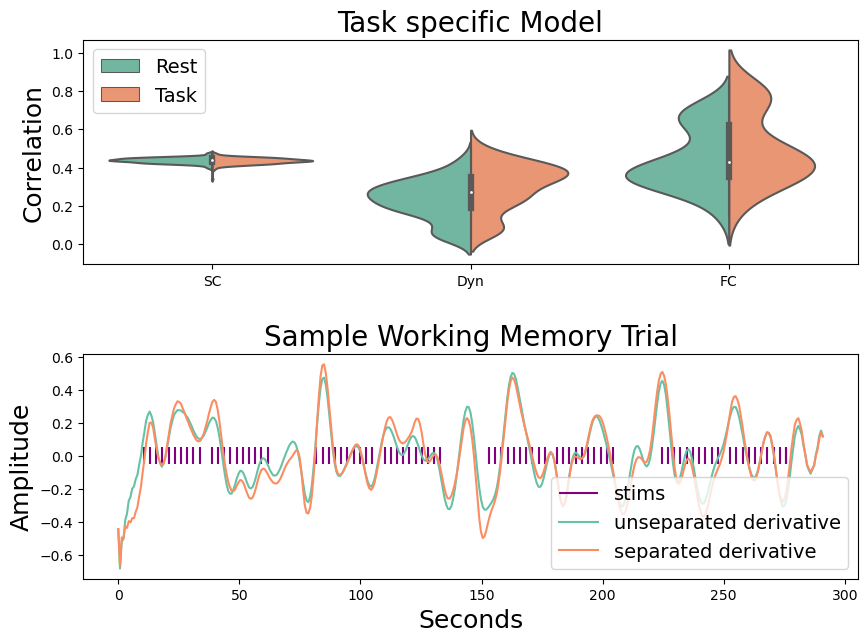

In [151]:
plt.rc('legend',fontsize=14) # using a size in points

import matplotlib.cm as cm

n_trial = 27

stims = behall[n_trial,4,:]

ttt = np.arange(0,405*0.72, 0.72)
# defining plot size

fig, axes = plt.subplots(2,1, figsize=(10, 7))

plt.subplots_adjust(hspace=0.4) 

colors = cm.Set2(range(4))
 
# single line
for x in stims:
    axes[1].vlines(x*0.72, ymin = -0.05, ymax = 0.05,colors = 'purple')

axes[1].vlines(x*0.72, ymin = -0.05, ymax = 0.05,colors = 'purple', label = 'stims')
axes[1].plot(ttt, x_dot_computed[n_trial,57,:], color = colors[0], label = 'unseparated derivative')
axes[1].plot(ttt, diff[n_trial,57,:], color = colors[1] ,label = 'separated derivative')
axes[1].set_xlabel('Seconds', fontsize=18)
axes[1].set_ylabel('Amplitude', fontsize=18)
axes[1].set_title('Sample Working Memory Trial', fontsize=20)
axes[1].legend()






gh = np.array(["Task" for x in range(443)])
nh = np.array(["Rest" for x in range(443)])
gh2 = np.array(["Task" for x in range(84)])
nh2 = np.array(["Rest" for x in range(84)])
gh3 = np.array(["Task" for x in range(40)])
nh3 = np.array(["Rest" for x in range(40)])

mylab = np.hstack([nh, gh, nh2, gh2, nh3, gh3])
mydat = np.hstack([corr1_r, corr1, a1_rest, a1_wm, corr_vals_int_rest, corr_vals_int_wm])
ident = np.array(["SC" for x in range(443*2)])
ident2 = np.array(["Dyn" for x in range(84*2)])
ident3 = np.array(["FC" for x in range(40*2)])


idenall = np.hstack([ident, ident2, ident3])

df = pd.DataFrame({"Label": idenall,
                    "Separated vs Unseparated": mylab,
                    "Data": mydat,
                  })




sns.violinplot(ax = axes[0] ,x = 'Label', y = 'Data', hue="Separated vs Unseparated",  palette=color_palette, data=df, split = True)

axes[0].set_xlabel(' ', fontsize=18)
axes[0].set_ylabel('Correlation', fontsize=18)
axes[0].set_title('Task specific Model', fontsize=20)
axes[0].legend(loc='upper left')


In [32]:
###loop through each trial take weighted when the stimulus comes to align across delay period 
### delay period is limited to 20 as larger values run over the timelimit at the end of the trial
from scipy import integrate
from joblib import Parallel, delayed
n_vox = 84


delay_period = 20
wm_all = np.transpose(wm_multiple, axes = (0,2,1))

def per_trial(data4d, beh_var, nn):
    toreturn = np.zeros((80,nn, delay_period))    
    
    print(np.shape(data4d))
    for j in range(80):
        stim_tt =  beh_var[4,j]
        
        t1 = int(np.floor(stim_tt))
        t2 = int(np.ceil(stim_tt))
        aaa= (stim_tt-t1)
        bbb= (t2-stim_tt)
        for k in range(delay_period):
            toreturn[j,:,k]= data4d[:,t1+k]*aaa + data4d[:,t2+k]*bbb
    return toreturn


mag_null = np.stack(Parallel(n_jobs=-1)(delayed(per_trial)(wm_all[i,:,:], behall[i,:,:], n_vox) for i in range(n_subj*2)))
der_null = np.stack(Parallel(n_jobs=-1)(delayed(per_trial)(x_dot_computed[i,:,:], behall[i,:,:], n_vox) for i in range(n_subj*2)))
der_pred = np.stack(Parallel(n_jobs=-1)(delayed(per_trial)(x_dot_predicted[i,:,:], behall[i,:,:], n_vox) for i in range(n_subj*2)))
der_diff = np.stack(Parallel(n_jobs=-1)(delayed(per_trial)(diff[i,:,:], behall[i,:,:], n_vox) for i in range(n_subj*2)))

       

In [33]:
####integrates from the first value the derivative, predicted derivative, and regressed derivative

def integrate_from_init(data, init, nn):
    toreturn = np.zeros((80, delay_period-1, nn))
    single = np.ones((delay_period-1, nn))
    for j in range(80):
        toreturn[j,:,:] = [integrate.simpson(data[j,:,:x], dx=0.72) + init[j,:,0] for x in range(1,delay_period)]
    return toreturn

zint= np.zeros((80,n_vox,delay_period))
mag_int = np.stack(Parallel(n_jobs=-1)(delayed(integrate_from_init)(der_diff[i,:,:,:], mag_null[i,:,:,:], n_vox) for i in range(n_subj*2)))
mag_int_null = np.stack(Parallel(n_jobs=-1)(delayed(integrate_from_init)(der_null[i,:,:,:], mag_null[i,:,:,:], n_vox) for i in range(n_subj*2)))
mag_int_pred = np.stack(Parallel(n_jobs=-1)(delayed(integrate_from_init)(der_pred[i,:,:,:], mag_null[i,:,:,:], n_vox) for i in range(n_subj*2)))


In [34]:
#calculates average response of derivaitve and magnitude
mag_avg_null = np.average(np.reshape(mag_int_null, (894*80, delay_period-1, n_vox)), axis = 0)
mag_avg_diff = np.average(np.reshape(mag_int, (894*80, delay_period-1,n_vox )), axis = 0)

der_avg_null = np.average(np.reshape(der_null, (894*80, n_vox, delay_period)), axis = 0)
der_avg_diff = np.average(np.reshape(der_diff, (894*80, n_vox, delay_period)), axis = 0)

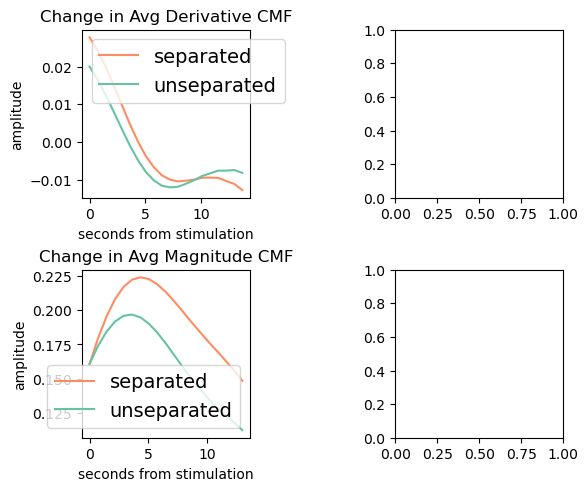

In [35]:
fig, axes = plt.subplots(2,2, constrained_layout=True)

nspsp = 58 #CMF which for working memory has highest correlates to derivative


ttt = np.arange(0, 0.72*20,0.72)

axes[0,0].plot(ttt, der_avg_diff[nspsp,:], color = colors[1], label= 'separated')
axes[0,0].plot(ttt, der_avg_null[nspsp,:], color = colors[0],label= 'unseparated')
axes[0,0].set_xlabel('seconds from stimulation')
axes[0,0].set_ylabel('amplitude')
axes[0,0].set_title('Change in Avg Derivative CMF')

axes[0,0].legend()
axes[0,0].set_box_aspect(1)

axes[1,0].plot(ttt[:19], mag_avg_diff[:,nspsp], color = colors[1], label= 'separated')
axes[1,0].plot(ttt[:19], mag_avg_null[:,nspsp], color = colors[0], label= 'unseparated')
axes[1,0].set_ylabel('amplitude')
axes[1,0].set_xlabel('seconds from stimulation')
axes[1,0].set_title('Change in Avg Magnitude CMF')

axes[1,0].legend()
axes[1,0].set_box_aspect(1)

axes[0,1].set_box_aspect(1)
axes[1,1].set_box_aspect(1)

plt.show()

In [36]:
#### get all valid indices for zero/two for all 4 categories
#### used to generate behavioral correlates per cateogory


def ind2sub(array_shape, ind):
    rows = np.floor(ind.astype('int') / array_shape[1])
    cols = (ind.astype('int') % array_shape[1]) # or numpy.mod(ind.astype('int'), array_shape[1])
    return (rows, cols)

valid = np.where(behall[:,1,:].flatten() == 1)
zeroback = np.where(behall[:,3,:].flatten() == 0)
twoback = np.where(behall[:,3,:].flatten() != 0)

validzero = np.intersect1d(valid, zeroback)
a_v0, b_v0= ind2sub([894,80],np.array(validzero))

validtwo = np.intersect1d(valid, twoback)
a_v2, b_v2= ind2sub([894,80],np.array(validtwo))

tool = np.where(behall[:,2,:].flatten() == 0)
face = np.where(behall[:,2,:].flatten() == 1)
body = np.where(behall[:,2,:].flatten() == 2)
place = np.where(behall[:,2,:].flatten() == 3)

valid_tool_zero = np.intersect1d(validzero, tool)
valid_tool_two = np.intersect1d(validtwo, tool)

valid_face_zero = np.intersect1d(validzero, face)
valid_face_two = np.intersect1d(validtwo, face)

valid_body_zero = np.intersect1d(validzero, body)
valid_body_two = np.intersect1d(validtwo, body)

valid_place_zero = np.intersect1d(validzero, place)
valid_place_two = np.intersect1d(validtwo, place)

all_indx = []
all_indx.append(valid_tool_zero.tolist())
all_indx.append(valid_face_zero.tolist())
all_indx.append(valid_body_zero.tolist())
all_indx.append(valid_place_zero.tolist())
all_indx.append(valid_tool_two.tolist())
all_indx.append(valid_face_two.tolist())
all_indx.append(valid_body_two.tolist())
all_indx.append(valid_place_two.tolist())


In [162]:
#### Correlate each value of the spatial temporal signal independently with behavioral correlates
#### namely for each j and t in x(j,t) create a vector and then compare it with behavioral correlates
#### to get the correlation for each j and t for each category

import itertools
magall_corr = np.zeros((8,n_vox, delay_period)) #unseparated
magall_pred_corr = np.zeros((8,n_vox, delay_period-1)) #separated
magall_predint_corr = np.zeros((8,n_vox, delay_period-1)) #network

derall_corr = np.zeros((8,n_vox, delay_period)) #unseparated
derall_pred_corr = np.zeros((8,n_vox, delay_period)) #separated
derall_diff_corr = np.zeros((8,n_vox, delay_period)) #network


for zzz in range(8):
    indxs_a, indxs_b = ind2sub([894,80],np.array(all_indx[zzz]))
    rt_comp = np.array([behall[int(indxs_a[i]), 0, int(indxs_b[i])] for i in range(len(indxs_a))])
    
    mag_comp = np.array([mag_null[int(indxs_a[i]), int(indxs_b[i]),:,:] for i in range(len(indxs_a))])
    mag_pred_comp = np.transpose(np.array([mag_int[int(indxs_a[i]), int(indxs_b[i]),:,:] for i in range(len(indxs_a))]) , (0,2,1))
    mag_predint_comp = np.transpose(np.array([mag_int_pred[int(indxs_a[i]), int(indxs_b[i]),:,:] for i in range(len(indxs_a))]) , (0,2,1))
    
    
    der_comp = np.array([der_null[int(indxs_a[i]), int(indxs_b[i]),:,:] for i in range(len(indxs_a))])
    der_pred_comp = np.array([der_pred[int(indxs_a[i]), int(indxs_b[i]),:,:] for i in range(len(indxs_a))])
    der_diff_comp = np.array([der_diff[int(indxs_a[i]), int(indxs_b[i]),:,:] for i in range(len(indxs_a))])
    
    magall_corr[zzz] = np.reshape([np.corrcoef(mag_comp[:,i,j], rt_comp)[0,1] for i, j in itertools.product(range(n_vox), range(delay_period))] , (n_vox,delay_period))
    magall_pred_corr[zzz] = np.reshape([np.corrcoef(mag_pred_comp[:,i,j] , rt_comp)[0,1] for i, j in itertools.product(range(n_vox), range(delay_period-1))] , (n_vox,delay_period-1))
    magall_predint_corr[zzz] = np.reshape([np.corrcoef(mag_predint_comp[:,i,j] , rt_comp)[0,1] for i, j in itertools.product(range(n_vox), range(delay_period-1))] , (n_vox,delay_period-1))
    
    
    derall_corr[zzz] = np.reshape([np.corrcoef(der_comp[:,i,j], rt_comp)[0,1] for i, j in itertools.product(range(n_vox), range(delay_period))] , (n_vox,delay_period))
    derall_pred_corr[zzz] = np.reshape([np.corrcoef(der_pred_comp[:,i,j], rt_comp)[0,1] for i, j in itertools.product(range(n_vox), range(delay_period))] , (n_vox,delay_period))
    derall_diff_corr[zzz] = np.reshape([np.corrcoef(der_diff_comp[:,i,j], rt_comp)[0,1] for i, j in itertools.product(range(n_vox), range(delay_period))] , (n_vox,delay_period))
    

### average for 0 back and 2 back magnitude
mag_corrs_0back = np.average(magall_corr[:4,:,:], axis =0)
mag_pred_corrs_0back = np.average(magall_pred_corr[:4,:,:], axis =0)
mag_net_corrs_0back = np.average(magall_predint_corr[:4,:,:], axis =0)

mag_corrs_2back = np.average(magall_corr[4:8,:,:], axis =0)
mag_pred_corrs_2back = np.average(magall_pred_corr[4:8,:,:], axis =0)
mag_net_corrs_2back = np.average(magall_predint_corr[4:8,:,:], axis =0)

nsp = np.where(mag_corrs_0back[:,7]> 0.175)  #gives 10 percent of highest correlated ROI
nspsp = np.squeeze(np.where(mag_corrs_0back[:,7] == np.max(mag_corrs_0back[:,7]))) #gives highest correlated ROI


### average for 0 back and 2 back derivative

der_corrs_0back = np.average(derall_corr[:4,:,:], axis =0)
der_pred_corrs_0back = np.average(derall_pred_corr[:4,:,:], axis =0)
der_diff_corrs_0back = np.average(derall_diff_corr[:4,:,:], axis =0)


der_corrs_2back = np.average(derall_corr[4:8,:,:], axis =0)
der_pred_corrs_2back = np.average(derall_pred_corr[4:8,:,:], axis =0)
der_diff_corrs_2back = np.average(derall_diff_corr[4:8,:,:], axis =0)

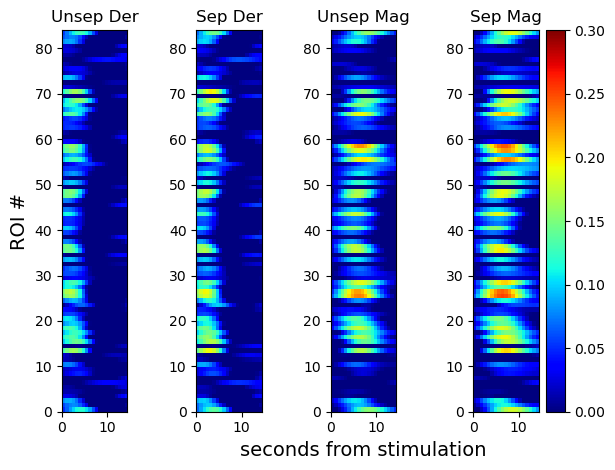

In [38]:
#### plot for cell above
fig, axes = plt.subplots(1,4)

ttt = np.arange(0, 0.72*20, 0.72)

axes[0].imshow( der_corrs_0back, 'jet', clim = [0,0.3], extent=[ 0, 20*0.72, 0, n_vox])
axes[0].set_title('Unsep Der')
axes[0].set_ylabel('ROI #', fontsize = 14)

axes[1].imshow(der_diff_corrs_0back, 'jet', clim = [0,0.3], extent=[ 0, 20*0.72, 0, n_vox])
axes[1].set_title('Sep Der')

axes[2].imshow(mag_corrs_0back, 'jet', clim = [0,0.3], extent=[ 0, 20*0.72, 0, n_vox])
axes[2].set_title('Unsep Mag')
axes[2].set_xlabel('seconds from stimulation', fontsize = 14)


im4 = axes[3].imshow(mag_pred_corrs_0back, 'jet', clim = [0,0.3], extent=[ 0, 20*0.72, 0, n_vox])
axes[3].set_title('Sep Mag')

fig.colorbar(im4, ax=axes[3] )

fig.tight_layout()
fig.savefig('magdertime.png')

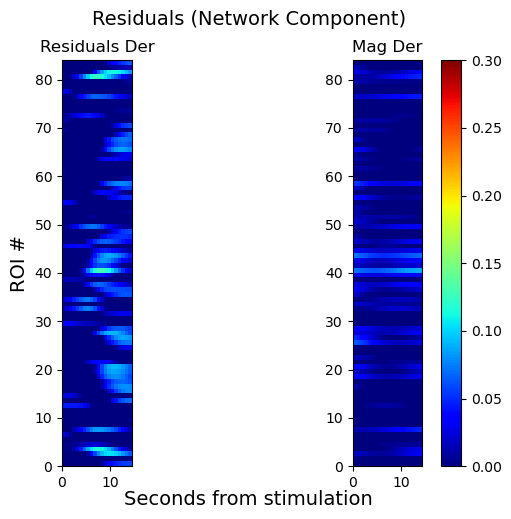

In [192]:
fig, axes = plt.subplots(1,2)

axes[0].imshow(der_pred_corrs_0back, 'jet', clim = [0,0.3], extent=[ 0, 20*0.72, 0, n_vox])
axes[0].set_title('Residuals Der')
axes[0].set_ylabel('ROI #', fontsize = 14)
im4 = axes[1].imshow(mag_net_corrs_0back , 'jet', clim = [0,0.3], extent=[ 0, 20*0.72, 0, n_vox])
axes[1].set_title('Mag Der')
#axes[0].set_xlabel('seconds from stimulation', fontsize = 14)
fig.colorbar(im4, ax=axes[1] )
fig.text(0.55, 0, 'Seconds from stimulation', ha='center', fontsize=14)
fig.text(0.55, 1, 'Residuals (Network Component)', ha='center', fontsize=14)

plt.tight_layout()


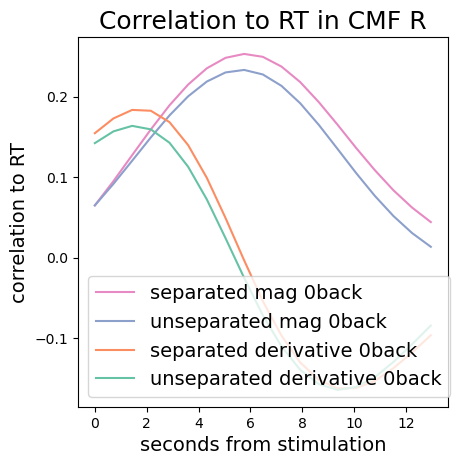

In [39]:
#### same plot as cell above but for a single ROI namely the CMF

nspsp = 58

fig = plt.figure()
ax = plt.axes()
ttt = np.arange(0, 0.72*19, 0.72)

plt.plot(ttt, mag_pred_corrs_0back[nspsp,:],color = colors[3]  , label= 'separated mag 0back')
plt.plot(ttt, mag_corrs_0back[nspsp,:19], color = colors[2]  ,label = 'unseparated mag 0back')

plt.plot(ttt, der_diff_corrs_0back[nspsp,:19], color = colors[1] , label= 'separated derivative 0back')
plt.plot(ttt, der_corrs_0back[nspsp,:19], color = colors[0] , label = 'unseparated derivative 0back')

plt.ylabel('correlation to RT', fontsize = 14)
plt.xlabel('seconds from stimulation', fontsize = 14)
plt.title('Correlation to RT in CMF R', fontsize = 18)
plt.legend()

ax.set_box_aspect(1)

fig.savefig('CMF_dermag.png')

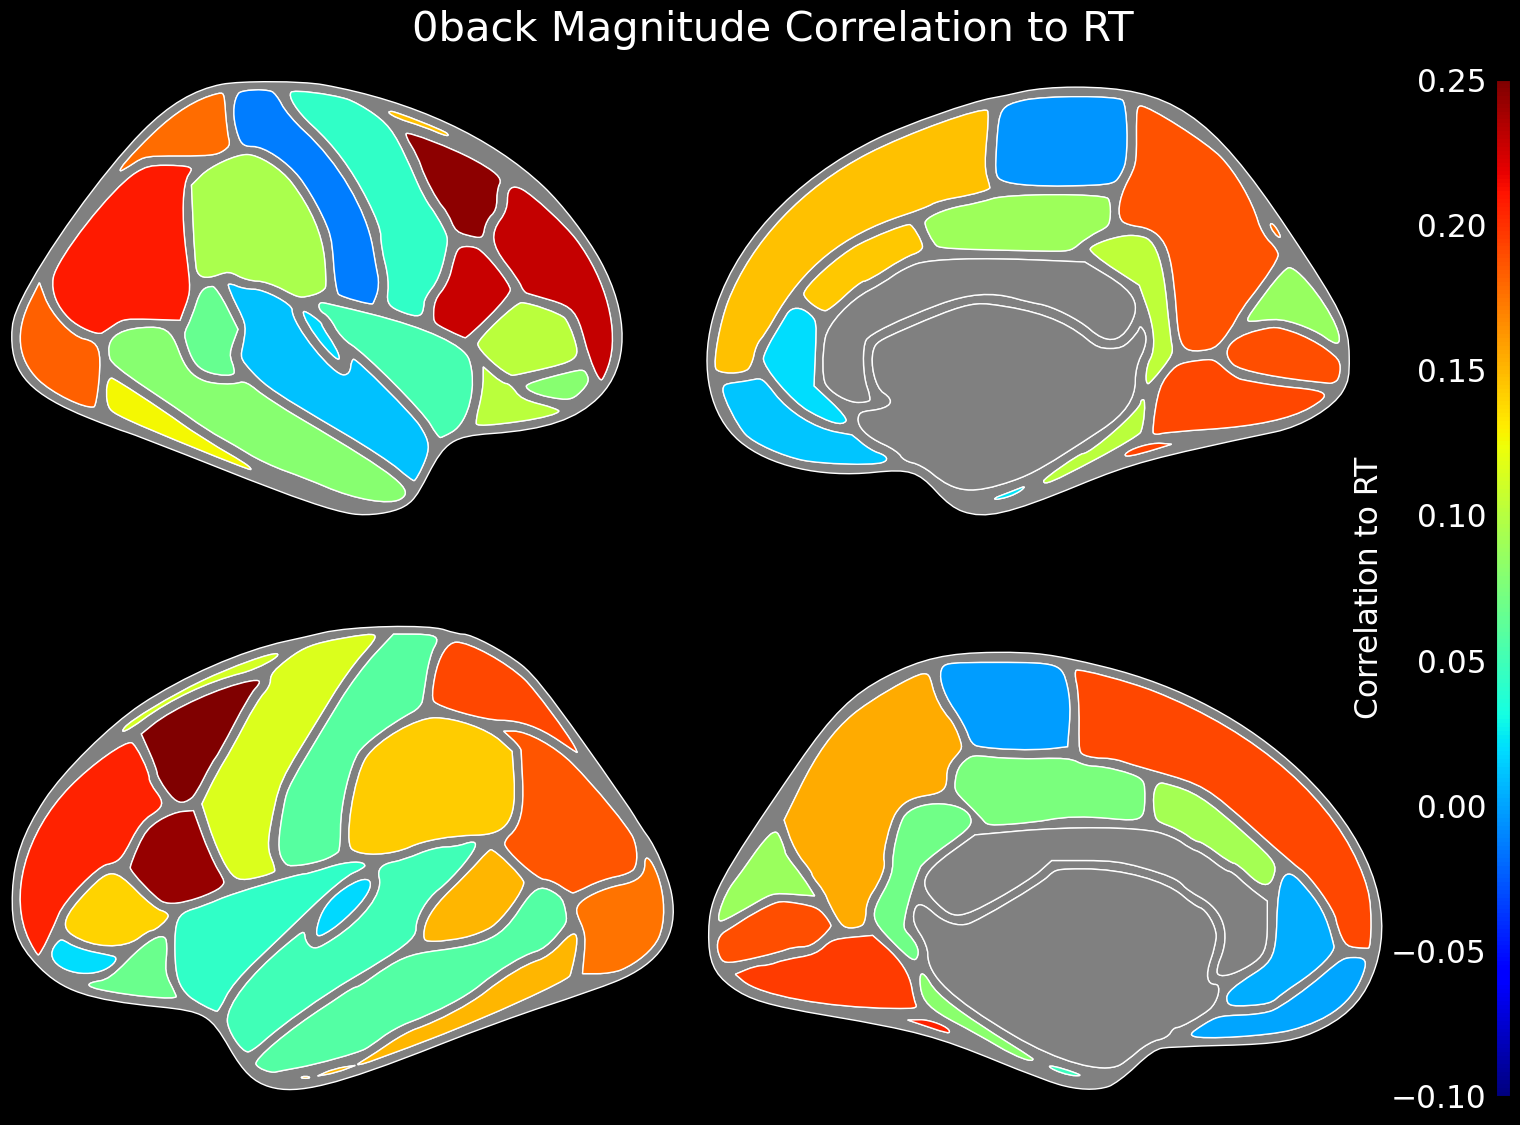

<Figure size 640x480 with 0 Axes>

In [43]:
#### Cortical plot at peak correlation to behavioral variables
datainf = {(roi_cortical[i]) : float(np.max(mag_pred_corrs_0back[i+8,:])) 
        for i in range(68)}
ggseg.plot_dk(datainf, background='k', edgecolor='w', cmap='jet', vminmax = [-0.1,0.25],
              bordercolor='gray', ylabel='Correlation to RT', title='0back Magnitude Correlation to RT', fontsize =30)

fig = plt.gcf()
fig.savefig('somebrainmaps.png')

In [60]:
##### Take the spatial Temporal Pattern and build a linear model in order to predict the behavioral coefficients
##### Train with 90 percent test with 10 percent run 10 fold cross validation


from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler


mag_ridge = np.zeros((8,10))
mag_pred_ridge = np.zeros((8,10))
coefs_pred = np.zeros((8,10,n_vox,30))  #taking delay period of 15 instead of 20 to reduce computation time
coefs_null = np.zeros((8,10,n_vox,30))  #one for magnitude and one for delay equals 30



null_pred = []
null_true_pred = []

reg_pred = []
reg_true_pred= []


for juj in range(8):
    indxs_a, indxs_b = ind2sub([894,80],np.array(all_indx[juj]))
    
    
    y = np.array([behall[int(indxs_a[i]), 0, int(indxs_b[i])] for i in range(len(indxs_a))])

    predictors_der = np.reshape(np.array([der_null[int(indxs_a[i]), int(indxs_b[i]),:,:15] for i in range(len(indxs_a))]), [len(y), n_vox*15])
    predictors_derdiff = np.reshape(np.array([der_pred[int(indxs_a[i]), int(indxs_b[i]),:,:15] for i in range(len(indxs_a))]), [len(y), n_vox*15])
    predictors_mag = np.reshape(np.array([mag_null[int(indxs_a[i]), int(indxs_b[i]),:,:15] for i in range(len(indxs_a))]), [len(y), n_vox*15])
    predictors_magpred = np.reshape(np.transpose(np.array([mag_int[int(indxs_a[i]), int(indxs_b[i]),:15,:] for i in range(len(indxs_a))]) , (0,2,1)) , [len(y), n_vox*(15)])

    predictors_all_pred = np.hstack([predictors_magpred, predictors_derdiff])
    predictors_all_null = np.hstack([predictors_mag, predictors_der])
    
    ss1 = StandardScaler(with_mean = True)
    ss2 = StandardScaler(with_mean = True)
    
    
    for cross in range(10):
        raindx = np.array([int(x) for x in np.random.permutation(y)])
        gg = int(np.floor(len(y)*0.9))
        
        xtrain_null = ss1.fit_transform(predictors_all_null[raindx[:gg],:])
        xtest_null = ss1.transform(predictors_all_null[raindx[gg:],:])
        
        
        clf1 = ElasticNet(alpha=1,  l1_ratio=0.95, max_iter=10000).fit( xtrain_null , y[raindx[:gg]])
        pred_y = clf1.predict( xtest_null )
        mag_ridge[juj, cross] = np.corrcoef(y[raindx[gg:]], pred_y)[0,1]
        null_true_pred.append(y[raindx[gg:]])
        null_pred.append(pred_y)
        coefs_null[juj, cross,:,:] = np.reshape(clf1.coef_, [n_vox,30])

        xtrain_pred = ss2.fit_transform(predictors_all_pred[raindx[:gg],:])
        xtest_pred = ss2.transform(predictors_all_pred[raindx[gg:],:])
        
        clf = ElasticNet(alpha=1,  l1_ratio=0.95, max_iter= 10000).fit(xtrain_pred , y[raindx[:gg]])
        pred_y = clf.predict(xtest_pred)
        reg_true_pred.append(y[raindx[gg:]])
        reg_pred.append(pred_y)
        mag_pred_ridge[juj, cross] = np.corrcoef(y[raindx[gg:]], pred_y)[0,1]
        coefs_pred[juj, cross,:,:] = np.reshape(clf.coef_, [n_vox,30])



C:\Users\amrit\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e+05, tolerance: 6.614e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\amrit\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.540e+05, tolerance: 6.557e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\amrit\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.801e+05, toleranc

C:\Users\amrit\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.809e+05, tolerance: 6.905e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\amrit\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+06, tolerance: 6.902e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\amrit\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.520e+05, toleranc

0.6699692320200189
0.6637930523039826
0.637097706137353
0.6063614592991667


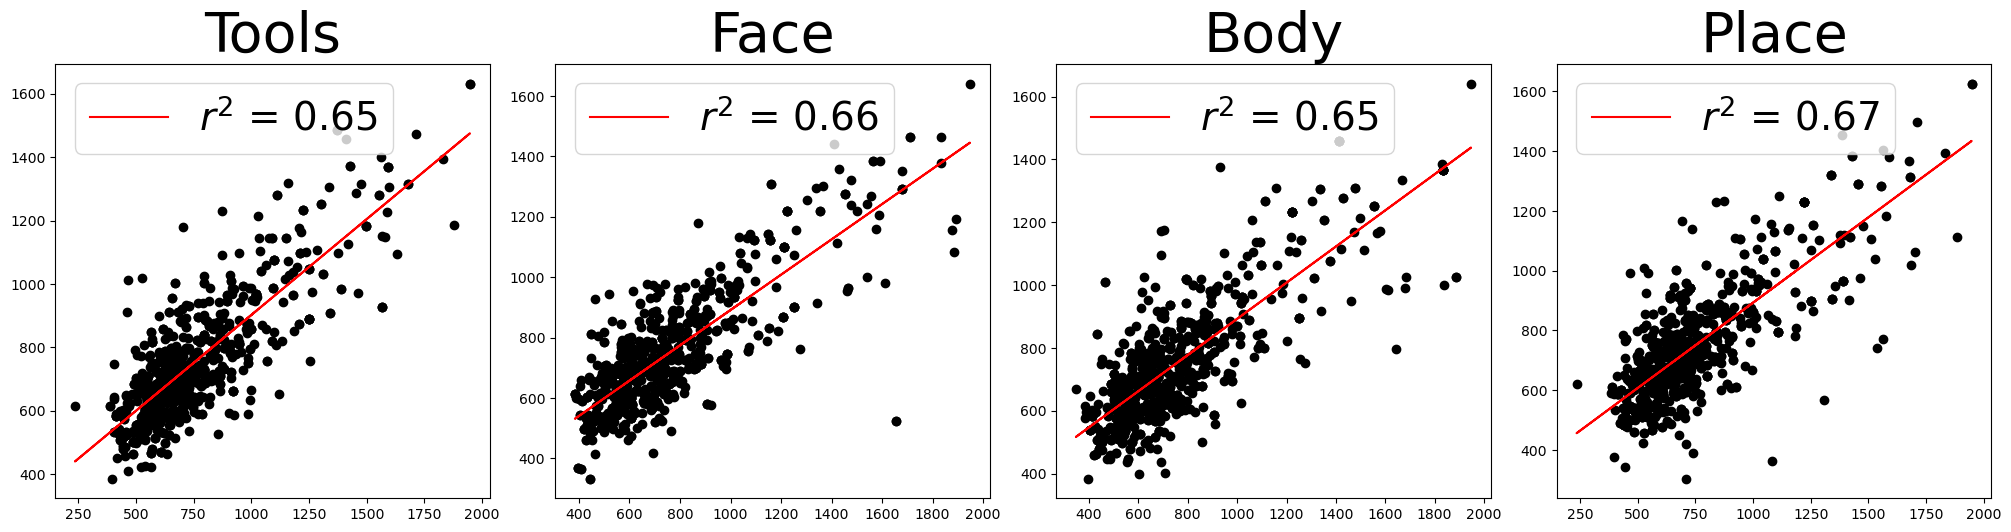

In [61]:
r_vals = ['$r^2$ = 0.65', '$r^2$ = 0.66', '$r^2$ = 0.65', '$r^2$ = 0.67']
plt.rcParams["figure.figsize"] = (20,80)
plt.rc('legend',fontsize=28) # using a size in points

fig, axes = plt.subplots(1,4, constrained_layout=True )

labels = ['Tools', 'Face', 'Body', 'Place']

for i in range(4):
    a, b = np.polyfit(reg_true_pred[i], reg_pred[i], 1)
    print(np.corrcoef(reg_true_pred[i], reg_pred[i])[0,1]**2)
    axes[i].scatter(reg_true_pred[i], reg_pred[i], c='black')
    axes[i].plot(reg_true_pred[i], a*reg_true_pred[i]+b, c='red', label=r_vals[i])
    axes[i].set_box_aspect(1)
    axes[i].set_title(labels[i], fontsize='40')
    axes[i].legend(loc = 2)

0.6520941111126781
0.6343832640254129
0.5946426699775476
0.6348859307308372


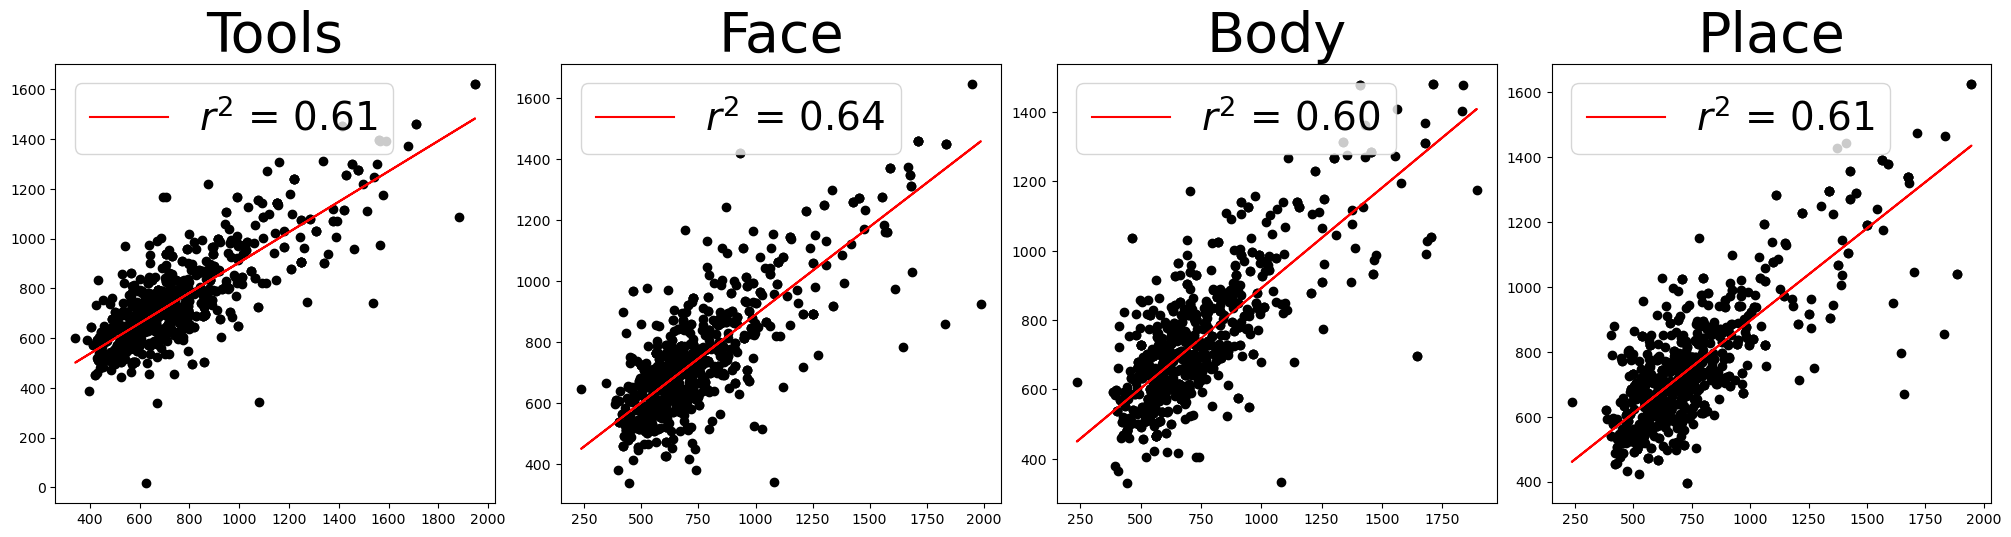

In [62]:
r_vals = ['$r^2$ = 0.61', '$r^2$ = 0.64', '$r^2$ = 0.60', '$r^2$ = 0.61']
plt.rcParams["figure.figsize"] = (20,80)
plt.rc('legend',fontsize=28) # using a size in points

fig, axes = plt.subplots(1,4, constrained_layout=True )

labels = ['Tools', 'Face', 'Body', 'Place']

for i in range(4,8):
    a, b = np.polyfit(reg_true_pred[i], reg_pred[i], 1)
    print(np.corrcoef(reg_true_pred[i], reg_pred[i])[0,1]**2)
    axes[i-4].scatter(reg_true_pred[i], reg_pred[i], c='black')
    axes[i-4].plot(reg_true_pred[i], a*reg_true_pred[i]+b, c='red', label=r_vals[i-4])
    axes[i-4].set_box_aspect(1)
    axes[i-4].set_title(labels[i-4], fontsize='40')
    axes[i-4].legend(loc = 2)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.5819129533122137


[]

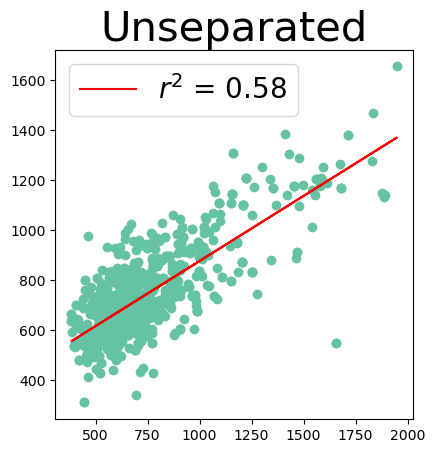

In [73]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline 

n = 1

a, b = np.polyfit(null_true_pred[n], null_pred[n], 1)
print(np.corrcoef(null_true_pred[n], null_pred[n])[0,1]**2)
plt.scatter(null_true_pred[n], null_pred[n], c=colors[0])
plt.plot(null_true_pred[n], a*null_true_pred[n]+b, c='red', label='$r^2$ = 0.58')
plt.title('Unseparated', fontsize='30')
plt.legend(loc = 2, fontsize="20")
plt.gca().set_aspect(1.2)
plt.plot()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.6637930523039826


[]

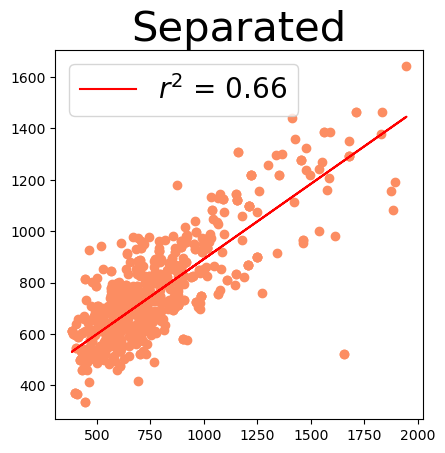

In [78]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline 

n = 1

a, b = np.polyfit(reg_true_pred[n], reg_pred[n], 1)
print(np.corrcoef(reg_true_pred[n], reg_pred[n])[0,1]**2)
plt.scatter(reg_true_pred[n], reg_pred[n], c=colors[1])
plt.plot(reg_true_pred[n], a*reg_true_pred[n]+b, c='red', label='$r^2$ = 0.66')
plt.title('Separated', fontsize='30')
plt.legend(loc = 2, fontsize="20")
plt.gca().set_aspect(1.2)
plt.plot()


In [92]:
my_corrs_reg2 = np.zeros((40,))
for x in range(40):
    my_corrs_reg2[x] = np.corrcoef(reg_true_pred[x+40], reg_pred[x+40])[0,1]
#    print(np.corrcoef(reg_true_pred[x], reg_pred[x])[0,1])

#print(np.mean(my_corrs_reg2)**2)
my_corrs_null2 = np.zeros((40,))

for x in range(40):
    my_corrs_null2[x]  = np.corrcoef(null_true_pred[x+40], null_pred[x+40])[0,1]


In [93]:

my_corrs_reg = np.zeros((40,))
for x in range(40):
    my_corrs_reg[x] = np.corrcoef(reg_true_pred[x], reg_pred[x])[0,1]
#    print(np.corrcoef(reg_true_pred[x], reg_pred[x])[0,1])
    
my_corrs_null = np.zeros((40,))
#print(np.mean(my_corrs_reg)**2)
for x in range(40,):
    my_corrs_null[x]  = np.corrcoef(null_true_pred[x], null_pred[x])[0,1]



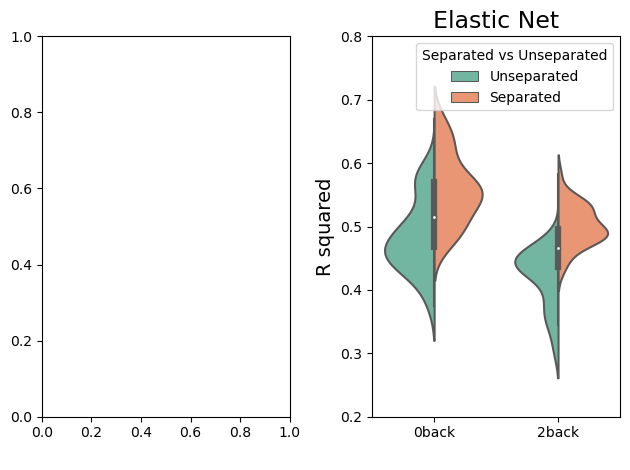

In [94]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


%matplotlib inline 

fig, axes = plt.subplots(1,2)

gh = np.array(["Separated" for x in range(40)])
nh = np.array(["Unseparated" for x in range(40)])
mylab = np.hstack([nh, gh, nh, gh])
mydat = np.hstack([my_corrs_null**2, my_corrs_reg**2, my_corrs_null2**2, my_corrs_reg2**2])
ident = np.array(["0back" for x in range(80)])
ident2 = np.array(["2back" for x in range(80)])



idenall = np.hstack([ident, ident2])

df = pd.DataFrame({"Label": idenall,
                    "Separated vs Unseparated": mylab,
                    "Data": mydat,
                  })




sns.violinplot(ax = axes[1] ,x = 'Label', y = 'Data', hue="Separated vs Unseparated",  palette=color_palette, data=df, split = True)
axes[1].set_ylabel("R squared", fontsize = 14)
axes[1].set_ylim([0.2, 0.8])
axes[1].set_title("Elastic Net", fontsize = 17)
axes[1].set_xlabel(' ')
fig.tight_layout()

fig.savefig('elasticnetregnull.png')

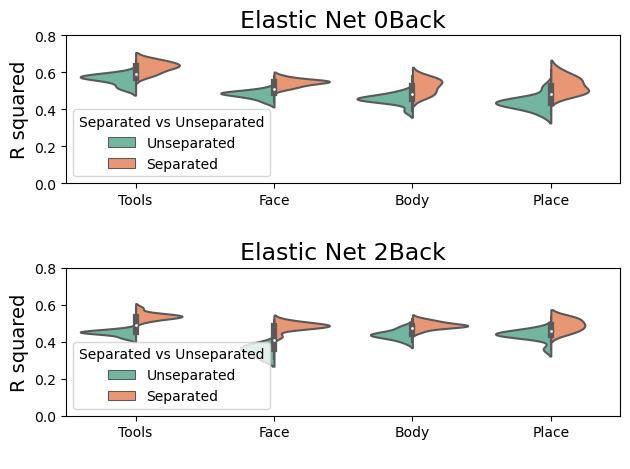

In [95]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


%matplotlib inline 

fig, axes = plt.subplots(2,1)

gh = np.array(["Separated" for x in range(40)])
nh = np.array(["Unseparated" for x in range(40)])

nnh = np.array(["Unseparated" for x in range(10)])
ggh = np.array(["Separated" for x in range(10)])

mylab = np.hstack([ nnh, ggh, nnh, ggh, nnh, ggh, nnh, ggh])
mydat = np.hstack([my_corrs_null[:10]**2, my_corrs_reg[:10]**2,  my_corrs_null[10:20]**2, my_corrs_reg[10:20]**2,  my_corrs_null[20:30]**2, my_corrs_reg[20:30]**2,  my_corrs_null[30:]**2, my_corrs_reg[30:]**2])

mydat2 = np.hstack([my_corrs_null2[:10]**2, my_corrs_reg2[:10]**2,  my_corrs_null2[10:20]**2, my_corrs_reg2[10:20]**2,  my_corrs_null2[20:30]**2, my_corrs_reg2[20:30]**2,  my_corrs_null2[30:]**2, my_corrs_reg2[30:]**2])


ident = np.array(["Average" for x in range(80)])
ident2 = np.array(["Tools" for x in range(20)])
ident3 = np.array(["Face" for x in range(20)])
ident4 = np.array(["Body" for x in range(20)])
ident5 = np.array(["Place" for x in range(20)])
#ident2 = np.array(["2back" for x in range(80)])



idenall = np.hstack([ident2, ident3, ident4, ident5])

df = pd.DataFrame({"Label": idenall,
                    "Separated vs Unseparated": mylab,
                    "Data": mydat,
                  })

df2 = pd.DataFrame({"Label": idenall,
                    "Separated vs Unseparated": mylab,
                    "Data": mydat2,
                  })


sns.violinplot(ax = axes[1] ,x = 'Label', y = 'Data', hue="Separated vs Unseparated",  palette=color_palette, data=df2, split = True)
axes[1].set_ylabel("R squared", fontsize = 14)
axes[1].set_ylim([0, 0.8])
axes[1].set_title("Elastic Net 2Back", fontsize = 17)
axes[1].set_xlabel(' ')
fig.tight_layout()

sns.violinplot(ax = axes[0] ,x = 'Label', y = 'Data', hue="Separated vs Unseparated",  palette=color_palette, data=df, split = True)
axes[0].set_ylabel("R squared", fontsize = 14)
axes[0].set_ylim([0, 0.8])
axes[0].set_title("Elastic Net 0Back", fontsize = 17)
axes[0].set_xlabel(' ')
fig.tight_layout()


fig.savefig('elasticnetregnull.png')

In [36]:
### Sweep the coefficients

c1 = np.arange(-1,3.2,0.2)
c2 =  np.arange(-3,1.2,0.2)

n_t = len(c1)

mag_0back_sweep = np.zeros((n_t,n_t))
mag_2back_sweep = np.zeros((n_t,n_t))

der_0back_sweep = np.zeros((n_t,n_t))
der_2back_sweep = np.zeros((n_t,n_t))

for n_i in range(n_t):
    print(n_i)
    for n_j in range(n_t):
        
        
        x_dot_predicted = np.zeros((n_subj*2,n_vox,n_time))
        x_dot_computed = np.zeros((n_subj*2,n_vox,n_time))
        
        
        for indx in range(447*2):
            x_dot_predicted[indx,:,:] = np.transpose(c1[n_i]*model.predict(wm_multiple[indx],) + c2[n_j]*wmmodel.predict(wm_multiple[indx],))
            x_dot_computed[indx,:,:] = np.transpose(wmmodel.differentiate( wm_multiple[indx], t=dt))
            diff[indx,:,:]= x_dot_computed[indx,:,:] - x_dot_predicted[indx,:,:]
        

        der_diff = np.stack(Parallel(n_jobs=-1)(delayed(per_trial)(diff[i,:,:], behall[i,:,:], n_vox) for i in range(n_subj*2)))
        mag_int = np.stack(Parallel(n_jobs=-1)(delayed(integrate_from_init)(der_diff[i,:,:,:], mag_null[i,:,:,:], n_vox) for i in range(n_subj*2)))

        
        magall_pred_corr = np.zeros((8,n_vox, delay_period-1))
        derall_diff_corr = np.zeros((8,n_vox, delay_period))


        for zzz in range(8):
            indxs_a, indxs_b = ind2sub([894,80],np.array(all_indx[zzz]))
            rt_comp = np.array([behall[int(indxs_a[i]), 0, int(indxs_b[i])] for i in range(len(indxs_a))])

            mag_pred_comp = np.transpose(np.array([mag_int[int(indxs_a[i]), int(indxs_b[i]),:,:] for i in range(len(indxs_a))]) , (0,2,1))
            der_diff_comp = np.array([der_diff[int(indxs_a[i]), int(indxs_b[i]),:,:] for i in range(len(indxs_a))])

            magall_pred_corr[zzz] = np.reshape([np.corrcoef(mag_pred_comp[:,i,j] , rt_comp)[0,1] for i, j in itertools.product(range(n_vox), range(delay_period-1))] , (n_vox,delay_period-1))
            derall_diff_corr[zzz] = np.reshape([np.corrcoef(der_diff_comp[:,i,j], rt_comp)[0,1] for i, j in itertools.product(range(n_vox), range(delay_period))] , (n_vox,delay_period))


        ### average for 0 back and 2 back magnitude
        mag_0back_sweep[n_i, n_j] = np.max(np.average(magall_pred_corr[:4,:,:], axis =0))
        mag_2back_sweep[n_i, n_j] = np.max(np.average(magall_pred_corr[4:8,:,:], axis =0))


        ### average for 0 back and 2 back derivative
        der_0back_sweep[n_i,n_j] = np.max(np.average(derall_diff_corr[:4,:,:], axis =0))
        der_2back_sweep[n_i,n_j] = np.max(np.average(derall_diff_corr[4:8,:,:], axis =0))
        
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


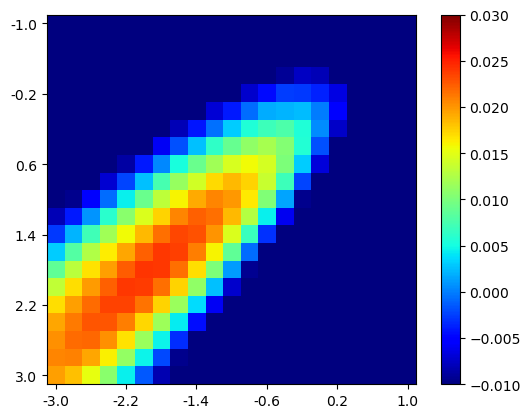

In [54]:
plt.imshow(mag_0back_sweep - mag_0back_sweep[5,15], 'jet')


plt.colorbar()
plt.yticks([0,4,8,12,16,20],np.round(c1[::4],1))
plt.xticks([0,4,8,12,16,20], np.round(c2[::4],1))

plt.clim([-0.01,0.03])

In [ ]:
resttask_max = [np.max(mag_pred_corrs_0back[x,:]) for x in nsp[0]]

##### To get the others just reran using different c1 c2 configurations


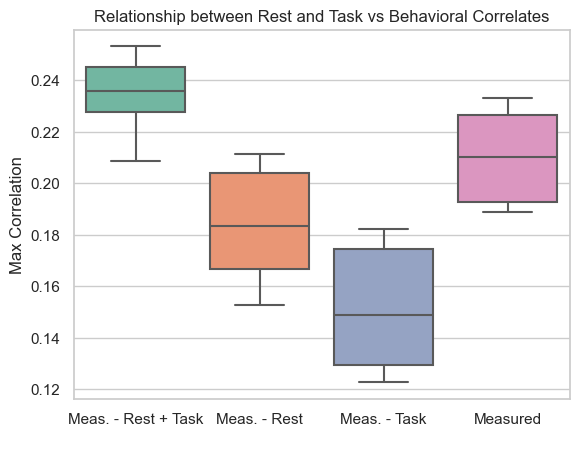

In [261]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


%matplotlib inline 
sns.set(style="whitegrid", palette="Set2")


data = {
    'Meas. - Rest + Task': resttask_max,  # Replace value1, value2, ... with your actual data
    'Meas. - Rest': rest_max,
    'Meas. - Task': task_max,
    'Measured': null_max
}

df = pd.DataFrame(data)

fig, ax = plt.subplots()



sns.boxplot(data=df, ax=ax)
ax.set_xlabel(' ')
ax.set_ylabel('Max Correlation')
ax.set_title('Relationship between Rest and Task vs Behavioral Correlates')

plt.show()